In [3]:
## Paper Plots Notebook:
        
##From loadD3Adata_Dallas.py:
from matplotlib.pyplot import *
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import LogNorm
from matplotlib.ticker import MultipleLocator
import numpy as np
import h5py
##From WT:
import datetime
import pytz
import os
import glob
from matplotlib import colors
import pandas
import csv
import pickle
%matplotlib inline
import beamcals
from beamcals import corr
from beamcals import concat
from beamcals import drone
from beamcals import bicolog
from beamcals import beammap
from beamcals import reduce_ccclass
import beamcals.plotting_utils as pu
import beamcals.fitting_utils as fu
import beamcals.geometry_utils as gu
import beamcals.time_utils as tu
import beamcals.reduce_ccclass as rc
from beamcals.sites import site
chimesite=site.site('../beamcals_venv/newburghlabdrone/beamcals/beamcals/sites/CHIME_config.npz')
chime_cylC=site.site('../beamcals_venv/newburghlabdrone/beamcals/beamcals/sites/CHIME_CylC_config_v2.npz')
from scipy.stats import pearsonr

#phase unwrap:
from skimage.restoration import unwrap_phase

# Display settings:
from IPython.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))


FileNotFoundError: [Errno 2] No such file or directory: '../beamcals_venv/newburghlabdrone/beamcals/beamcals/sites/CHIME_config.npz'

In [4]:
np.load('../../python/')

FileNotFoundError: [Errno 2] No such file or directory: '../beamcals_venv/newburghlabdrone/beamcals/beamcals/sites/CHIME_config.npz'

In [2]:
## Define functions for the reactive NF, FF, and range of the radiating NF [all units cm]:
    #inputs are dish diameter (D) and wavelength (Lambda) both in cm!
    
def Reactive_NF_Distance_m(D,Lambda):
    return (1.0/100.0)*0.62*np.sqrt((D**3.0)/Lambda)

def FF_Distance_m(D,Lambda):
    return (1.0/100.0)*2.0*(D**2.0)/Lambda

def Radiative_NF_Bounds_m(D,Lambda):
    return [Reactive_NF_Distance_m(D,Lambda),FF_Distance_m(D,Lambda)]

from scipy.optimize import curve_fit
from scipy.optimize import least_squares
## DEFN the Gauss Fit function:
def Gauss_opt(P,x,V):
    a,x0,sigma,k=P
    return a*np.exp(-(x-x0)**2.0/(2.0*sigma**2.0))+k-V

def linefunc_opt(P,x,V):
    m,b=P
    return m*x+b-V

def linefunc(P,x):
    m,b=P
    return m*x+b

def Parabfunc_opt(P,x,V):
    a,b,c=P
    return a*(x**2.0)+b*x+c-V

def Parabfunc(P,x):
    a,b,c=P
    return a*(x**2.0)+b*x+c

def telescopeCoords(HA,Dec,lat=49.320751,deg=False):
    '''Return telescope coordinates[
    y (sine of zenith angle) increasing to the North
    x increasing to the east
    for HA, Dec given in degrees
    if deg=True, y is[returned as[zenith angle in degrees[(North positive)
    '''
    # convert celestial coordinates[to theta,phi
    t = np.radians(90. - Dec)
    p = -1.*np.radians(HA)
    # convert theta,phi to X vector in celestial frame
    # x_hat = in equitorial plane pointing toward 0 HA
    # y_hat = in equitorial plane pointing toward -90 HA (East)
    # z_hat = north celestial pole
    x = np.sin(t)*np.cos(p)
    y = np.sin(t)*np.sin(p)
    z = np.cos(t)
    X = np.stack((x,y,z),axis=-1)
    # rotate X to X' in telescope frame
    # x'_hat = zenith
    # y'_hat = East
    # z'_hat = North
    beta = np.radians(lat)
    k = np.array([0,1,0])[np.newaxis,:]
    Xp = np.cos(beta)*X
    Xp += np.sin(beta)*np.cross(k,X)
    Xp += np.inner(X,k)*(1-np.cos(beta))*k
    # convert X' to theta',phi' in telescope frame
    bxp,byp,bzp = np.transpose(Xp)
    tp = np.arctan2(np.sqrt(bxp**2 + byp**2),bzp)
    pp = np.arctan2(byp,bxp)
    # convert theta',phi' to telescope x,y
    za = 0.5*np.pi - tp
    if deg:
        y = np.degrees(za) 
    else:
        y = np.sin(za)
    x = np.sin(tp)*np.sin(pp)
    return (y,x)

def ground_to_sph(x,y,lat=49.320751*(np.pi/180.0)):
    """Get the CIRS coordinates.

    Latitude is given in radians. Assumes z is positive

    Parameters
    ----------
    x : array_like
        The East projection of the angular position
    y : array_like
        The North projection of the angular position
    lat : array_like
        The latitude of the observatory.

    Returns
    -------
    ha, dec: array_like
        Hour Angle and declination in radians
    """
    z = np.sqrt(1 - x**2 - y**2)

    xe = z * np.cos(lat) - y * np.sin(lat)
    ye = x
    ze = y * np.cos(lat) + z * np.sin(lat)

    ha = -1 * np.arctan2(ye, xe)
    dec = np.arctan2(ze, np.sqrt(xe**2 + ye**2))

    return ha, dec

['drone_xyz_LC', 'drone_xyz_per_dish', 'Dfreq', 'RA_Dec_per_feed', 'telXY_per_feed']


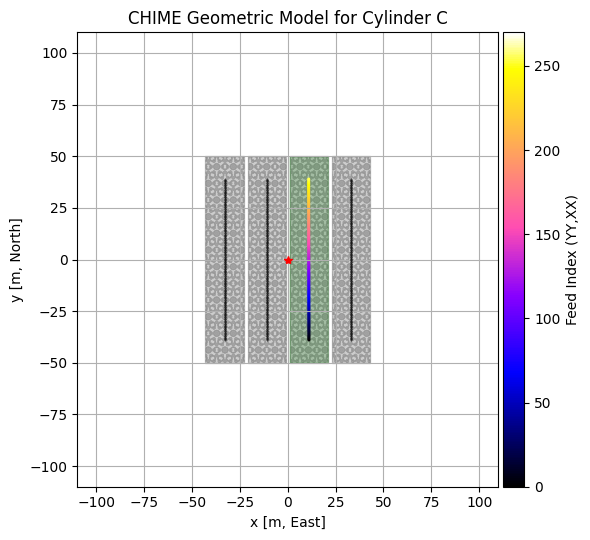

In [3]:
CHIME_ANG=0.071#deg

def CHIME_2d_Rot(X,Y,theta=CHIME_ANG):
    xp=X*np.cos(theta*np.pi/180.0)-Y*np.sin(theta*np.pi/180.0)
    yp=X*np.sin(theta*np.pi/180.0)+Y*np.cos(theta*np.pi/180.0)
    return [xp,yp]

Dcoords=np.load("../../Desktop/CHIME_IEEEpaper/CHIME_paperdata/CHIME_flight_coords.npz")
print(Dcoords.files)

fig,ax=subplots(nrows=1,ncols=1,figsize=(6,5.5),sharex=True,sharey=True)
xlim(-110,110)
ylim(-110,110)
plot(0,0,'r*')
for j in [-33,-11,11,33]:
    x=np.array([j-10,j+10])
    y1=np.array([-50,-50])
    y2=np.array([50,50])
    xf=j*np.ones(256)
    yf=np.linspace(-0.3048*(256/2),+0.3048*(256/2),256)
    xf0,yf0=CHIME_2d_Rot(xf,yf)
    x0,y10=CHIME_2d_Rot(x,y1)
    x0,y20=CHIME_2d_Rot(x,y2)
    fill_between(x,y1,y2,color='k',alpha=0.2,hatch='oooOO')
    if j in [-33,-11,33]:
        plot(xf,yf,'k.',markersize=0.5)
        #fill_between(x0,y10,y20,color='r',alpha=0.2)
        #plot(xf0,yf0,'r.',markersize=0.5)
    if j in [11]:
        fill_between(x0,y10,y20,color='g',alpha=0.2)
        im=ax.scatter(xf0,yf0,c=range(256),vmin=0,vmax=270,s=1,cmap='gnuplot2')
divider=make_axes_locatable(ax)
cax=divider.append_axes("right", size="5%", pad=0.05)
cbar=fig.colorbar(im,cax=cax)
cbar.set_label('Feed Index (YY,XX)')
ax.set_title("CHIME Geometric Model for Cylinder C")
ax.set_xlabel('x [m, East]')
ax.set_ylabel('y [m, North]')
ax.grid()
tight_layout()
# fig.savefig("../../Desktop/CHIME_Figures/CHIME_Model_0.png")

/tmp/ipykernel_70201/228507148.py:61: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


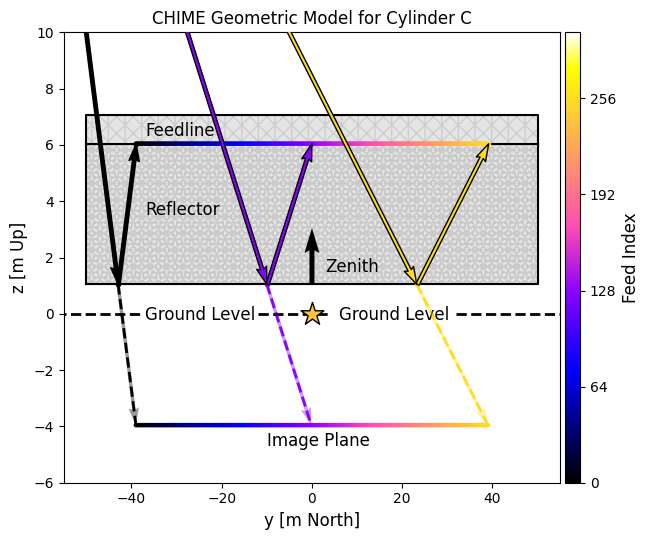

In [7]:
fig1,ax1=subplots(nrows=1,ncols=1,figsize=(6,5.5),sharex=True,sharey=True)
xlim(-55,55)
ylim(-6,10)
y=np.array([-50,50])
dx,dy,dz=[0,-214,290]
dx,dy,dz=[0,-65,29]
z1=np.array([1.047,1.047])
z2=np.array([6.047,6.047])
z3=np.array([7.047,7.047])
yf=np.linspace(-0.3048*(256/2),+0.3048*(256/2),256)
zf=(5.0+1.047)*np.ones(256)
zi=(1.047-5.0)*np.ones(256)
yi=np.linspace(-0.3048*(256/2),+0.3048*(256/2),256)
zb=1.047*np.ones(256)
fill_between(y,z1,z2,color='k',alpha=0.1,hatch='oooOO')
fill_between(y,z2,z3,color='k',alpha=0.1,hatch='|xX')
ax1.plot([y[0],y[-1],y[-1],y[0],y[0]],[1.047,1.047,7.047,7.047,1.047],'k')
ax1.plot([y[0],yi[0]],[6.047,6.047],'k')
ax1.plot([yi[-1],y[-1]],[6.047,6.047],'k')
ax1.set_title("CHIME Geometric Model for Cylinder C",fontsize='large')
ax1.set_xlabel('y [m North]',fontsize='large')
ax1.set_ylabel('z [m Up]',fontsize='large')
# ax1.grid()
tight_layout()


vecslope=((zi[:]-dz)/(yi[:]-dy))
veczints=(dz)-vecslope[:]*(dy)
yb=((zb-veczints)/vecslope)

#yb=[(dy/dz)*((((dz-zi[i])/(dy-yi[i]))*dy))/((dz-zi[i])/(dy-yi[i])) for i in range(256)]
#yb=[(-1.0*(dz-(((zi[i]-dz)/(yi[i]-dy))*dy)))/((zi[i]-dz)/(yi[i]-dy)) for i in range(256)]

colorsarr=cm.gnuplot2(np.linspace(0,1,300))
for i in [0,127,255]:
    ax1.plot([dy,yb[i],yf[i]],[dz,zb[i],zf[i]],'.-',c=colorsarr[i])
    ax1.quiver(yb[i],zb[i],yf[i]-yb[i],zf[i]-zb[i],angles='xy',scale_units='xy',scale=1,width=0.007,edgecolor='k',linewidth=1,color=colorsarr[i],zorder=8)
    ax1.quiver(dy,dz,yb[i]-dy,zb[i]-dz,angles='xy',scale_units='xy',scale=1,width=0.007,edgecolor='k',linewidth=1,color=colorsarr[i],zorder=9)
    ax1.quiver(yb[i],zb[i],yi[i]-yb[i],zi[i]-zb[i],angles='xy',scale_units='xy',scale=1,width=0.007,color=colorsarr[i],alpha=0.4,zorder=7)
    ax1.plot([yb[i],yi[i]],[zb[i],zi[i]],'--',linewidth=2,c=colorsarr[i])
    ## Test if the vectors are fucked up:
    #ax1.quiver(dy,dz,yi[i]-dy,zi[i]-dz,angles='xy',scale_units='xy',scale=1,width=0.007,color=colorsarr[i],alpha=0.4,zorder=7)
    
ax1.quiver(0,zb[0],0,2,angles='xy',scale_units='xy',scale=1, width=0.01, color=colorsarr[0])
ax1.text(3,1.5,"Zenith",fontsize='large')

ax1.plot([-12,4],[0,0],'k--',linewidth=2)
ax1.plot([-60,-38],[0,0],'k--',linewidth=2)
ax1.plot([32,60],[0,0],'k--',linewidth=2)
ax1.text(-37,-0.225,"Ground Level",fontsize='large')
ax1.text(6,-0.225,"Ground Level",fontsize='large')

im=ax1.scatter(yi,zi,c=range(256),vmin=0,vmax=300,s=5,cmap='gnuplot2')
im=ax1.scatter(yf,zf,c=range(256),vmin=0,vmax=300,s=5,cmap='gnuplot2')
divider=make_axes_locatable(ax1)
cax1=divider.append_axes("right", size="3%", pad=0.05)
cbar=fig1.colorbar(im,cax=cax1)
cbar.set_label('Feed Index',fontsize='large')
cbar.set_ticks(np.linspace(0,256,5))
cbar.set_ticklabels(np.linspace(0,256,5).astype(int))
fig.tight_layout()

ax1.text(-10,-4.7,"Image Plane",fontsize='large')
ax1.text(-37,6.3,"Feedline",fontsize='large')
ax1.text(-37,3.5,"Reflector",fontsize='large')
ax1.scatter([0],[0],color=colorsarr[240],marker='*',s=300,edgecolors='k',linewidth=1,zorder=10)
# savefig("../../Desktop/CHIME_Figures/CHIME_Model_4.png")
savefig("../../Desktop/CHIME_Model_5.png")

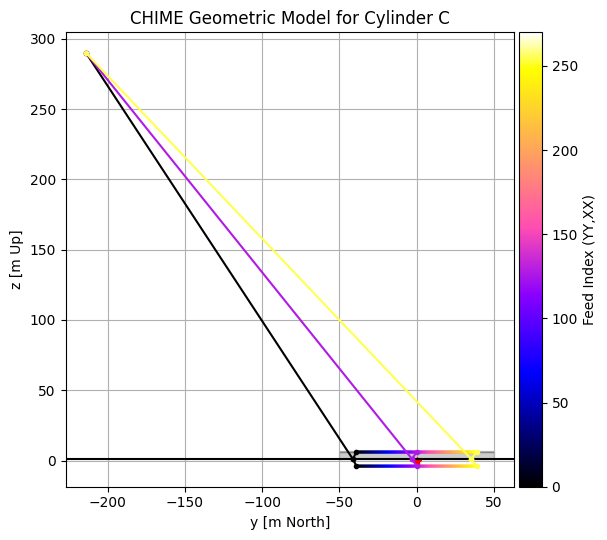

In [5]:
fig1,ax1=subplots(nrows=1,ncols=1,figsize=(6,5.5),sharex=True,sharey=True)
# xlim(-55,55)
# ylim(-6,10)
plot(0,0,'r*')
y=np.array([-50,50])
dx,dy,dz=[0,-214,290]
z1=np.array([1.047,1.047])
z2=np.array([6.047,6.047])
z3=np.array([7.047,7.047])
yf=np.linspace(-0.3048*(256/2),+0.3048*(256/2),256)
zf=6.047*np.ones(256)
fill_between(y,z1,z2,color='k',alpha=0.2)
fill_between(y,z2,z3,color='k',alpha=0.2)
im=ax1.scatter(yf,zf,c=range(256),vmin=0,vmax=270,s=1,cmap='gnuplot2')
divider=make_axes_locatable(ax1)
cax1=divider.append_axes("right", size="5%", pad=0.05)
cbar=fig1.colorbar(im,cax=cax1)
cbar.set_label('Feed Index (YY,XX)')
ax1.set_title("CHIME Geometric Model for Cylinder C")
ax1.set_xlabel('y [m North]')
ax1.set_ylabel('z [m Up]')
ax1.grid()
tight_layout()
ax1.axhline(01.047,color='k')
zi=-3.953*np.ones(256)
yi=np.linspace(-0.3048*(256/2),+0.3048*(256/2),256)
zb=1.047*np.ones(256)
yb=[(-1.0*(dz-(((zi[i]-dz)/(yi[i]-dy))*dy)))/((zi[i]-dz)/(yi[i]-dy)) for i in range(256)]
colorsarr=cm.gnuplot2(np.linspace(0,1,270))
for i in range(256)[::127]:
    ax1.plot([dy,yb[i],yf[i]],[dz,zb[i],zf[i]],'.-',c=colorsarr[i])
    ax1.plot([yb[i],yi[i]],[zb[i],zi[i]],'.--',c=colorsarr[i])
im=ax1.scatter(yi,zi,c=range(256),vmin=0,vmax=270,s=1,cmap='gnuplot2')
# savefig("../../Desktop/CHIME_Figures/CHIME_Model_2.png")

/tmp/ipykernel_70201/2948273497.py:28: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  im1=ax1.pcolormesh(Dcoords['drone_xyz_per_dish'][:256,tlb:tub,0],Dcoords['drone_xyz_per_dish'][:256,tlb:tub,1],np.outer(np.arange(256),np.ones(tub-tlb)),cmap="gnuplot2",vmin=0,vmax=270)
/tmp/ipykernel_70201/2948273497.py:29: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  im2=ax2.pcolormesh(Dcoords['RA_Dec_per_feed'][:256,tlb:tub,0],Dcoords['RA_Dec_per_feed'][:256,tlb:tub,1],np.outer(np.arange(256),np.ones(tub-tlb)),cmap="gnuplot2",vmin=0,vmax=270)
/tmp/ipykernel_70201/2948273497.py:30: UserWarning: 

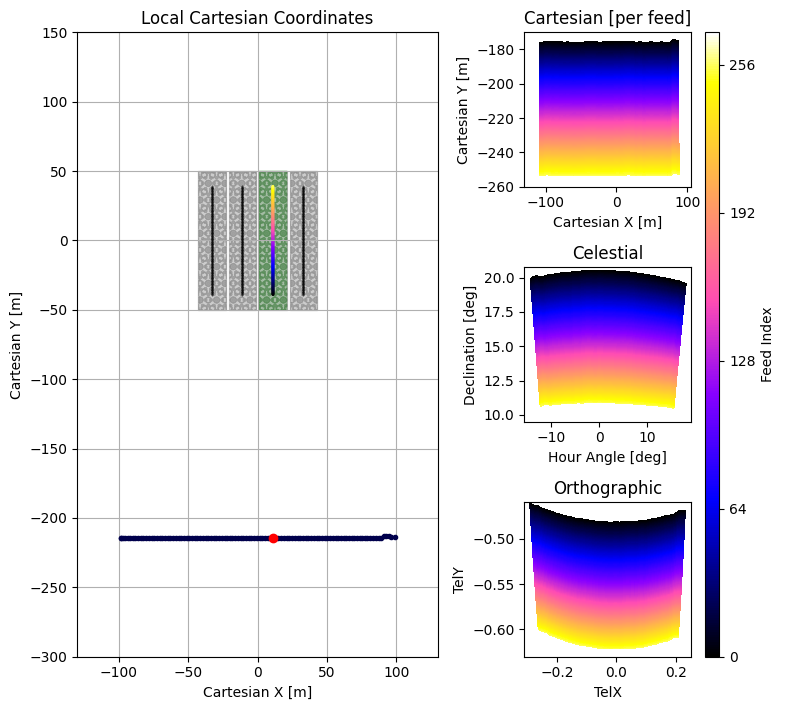

In [6]:
fig=figure(figsize=(7.2,7.2))
ax0=subplot2grid((3,3),(0,0),rowspan=3,colspan=2,aspect=1.0)
ax1=subplot2grid((3,3),(0,2))
ax2=subplot2grid((3,3),(1,2))
ax3=subplot2grid((3,3),(2,2))

for j in [-33,-11,11,33]:
    x=np.array([j-10,j+10])
    y1=np.array([-50,-50])
    y2=np.array([50,50])
    xf=j*np.ones(256)
    yf=np.linspace(-0.3048*(256/2),+0.3048*(256/2),256)
    xf0,yf0=CHIME_2d_Rot(xf,yf)
    x0,y10=CHIME_2d_Rot(x,y1)
    x0,y20=CHIME_2d_Rot(x,y2)
    ax0.fill_between(x,y1,y2,color='k',alpha=0.2,hatch='oooOO')
    if j in [-33,-11,33]:
        ax0.plot(xf,yf,'k.',markersize=0.5)
        #fill_between(x0,y10,y20,color='r',alpha=0.2)
        #plot(xf0,yf0,'r.',markersize=0.5)
    if j in [11]:
        ax0.fill_between(x0,y10,y20,color='g',alpha=0.2,hatch='oooOO')
        im0=ax0.scatter(xf0,yf0,c=range(256),vmin=0,vmax=270,s=1,cmap='gnuplot2')
# for tbds in [[1933,2035],[2044,2148]]:
for tbds in [[2044,2148]]:
    tlb,tub=tbds
    ax0.plot(Dcoords['drone_xyz_LC'][tlb:tub,0],Dcoords['drone_xyz_LC'][tlb:tub,1],'.',c=colorsarr[20])
    im1=ax1.pcolormesh(Dcoords['drone_xyz_per_dish'][:256,tlb:tub,0],Dcoords['drone_xyz_per_dish'][:256,tlb:tub,1],np.outer(np.arange(256),np.ones(tub-tlb)),cmap="gnuplot2",vmin=0,vmax=270)        
    im2=ax2.pcolormesh(Dcoords['RA_Dec_per_feed'][:256,tlb:tub,0],Dcoords['RA_Dec_per_feed'][:256,tlb:tub,1],np.outer(np.arange(256),np.ones(tub-tlb)),cmap="gnuplot2",vmin=0,vmax=270)        
    im3=ax3.pcolormesh(Dcoords['telXY_per_feed'][:256,tlb:tub,0],Dcoords['telXY_per_feed'][:256,tlb:tub,1],np.outer(np.arange(256),np.ones(tub-tlb)),cmap="gnuplot2",vmin=0,vmax=270)     
        
ax0.plot(11,Dcoords['drone_xyz_LC'][1989,1],'ro')
# ax0.axvline(11,color='k',linestyle='dashed')
# ax1.axvline(0,color='k',linestyle='dashed')
# ax2.axvline(Dcoords['RA_Dec_per_feed'][feedind,1989,0],color='k',linestyle='dashed')
# ax3.axvline(Dcoords['telXY_per_feed'][feedind,1989,0],color='k',linestyle='dashed')

xlabels=("Cartesian X [m]","Cartesian X [m]","Hour Angle [deg]","TelX")
ylabels=("Cartesian Y [m]","Cartesian Y [m]","Declination [deg]","TelY")
titles=("Local Cartesian Coordinates","Cartesian [per feed]","Celestial","Orthographic")
images=[im0,im1,im2,im3]
for i,ax in enumerate([ax0,ax1,ax2,ax3]):
    ax.set_title(titles[i])
    ax.set_xlabel(xlabels[i])
    ax.set_ylabel(ylabels[i])

ax0.grid()
ax0.set_xlim(-130,130)
ax0.set_ylim(-300,150)
ax1.set_xlim(-130,105)
ax1.set_ylim(-260,-170)
ax2.set_xlim(-15.5,19)
ax2.set_ylim(9.5,20.75)
ax3.set_xlim(-0.31,0.25)
ax3.set_ylim(-0.63,-0.46)   
fig.tight_layout()

cbar_ax = fig.add_axes([ax1.get_position().x0+ax1.get_position().width+0.02, ax0.get_position().y0, 0.02, ax0.get_position().height])
cbar=fig.colorbar(im0, cax=cbar_ax)
cbar.set_label('Feed Index')
cbar.set_ticks(np.linspace(0,256,5))
cbar.set_ticklabels(np.linspace(0,256,5).astype(int))
tight_layout()

# fig.savefig("../../Desktop/CHIME_Figures/Coordinate_Transformations_2.png", bbox_extra_artists=(cbar))


In [11]:
Sfits=np.load("../../Desktop/CHIME_IEEEpaper/CHIME_paperdata/CHIME_Solar_fits.npz")
Sfreq=Sfits['Sfreq']
print(Sfits.files)
Sfits["Spoptmask"].shape


['Spoptarr', 'Spoptmask', 'Spcovarr', 'Schisqarr', 'Sfreq', 'Stheta', 'Spols', 'Sphi', 'RA_Dec_Solar']


(1024, 2, 512, 4)

In [12]:
Dfits=np.load("../../Desktop/CHIME_IEEEpaper/CHIME_paperdata/CHIME_Drone_fits_RTKhmslPplus750cm.npz")
print(Dfits.files)
Dfits["Dpoptmask"].shape

['Dpoptarr', 'Dpoptmask', 'Dpcovarr', 'Dchisqarr', 'Dfreq', 'RA_Dec_per_feed', 'telXY_per_feed', 'Dpols']


(1024, 256, 2, 4)

/home/tyndall/python/beamcals_venv/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,


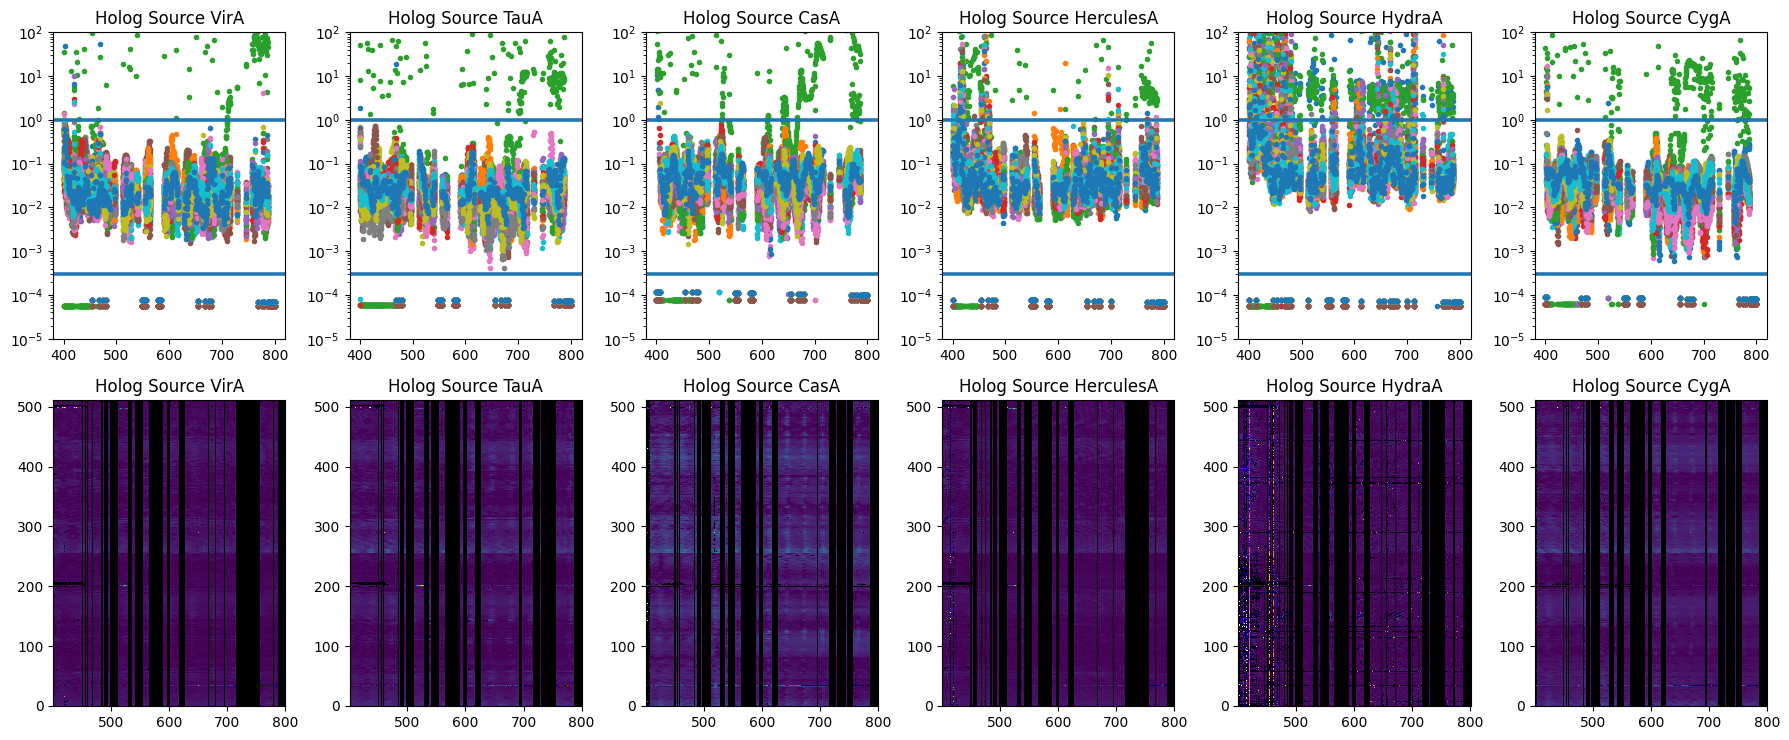

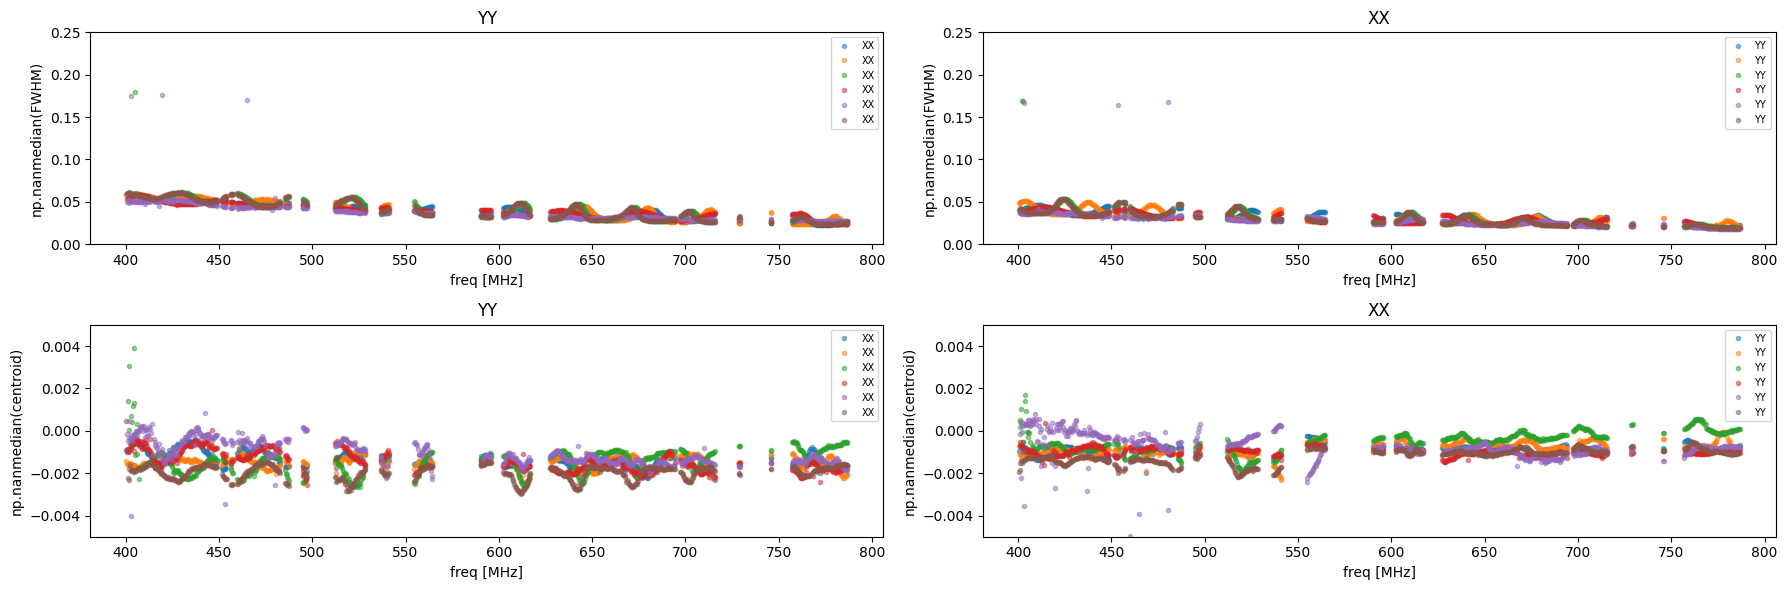

In [13]:
## LOAD Holography Data:
# HologXY=np.load("/home/tyndall/Desktop/holography_all_source_fits_telcoords_with_chisq.npz")
# Hchisqmin,Hchisqmax=[1e-2,1e0] # Old
# HologXY=np.load("/home/tyndall/Desktop/holo_vira_template_params_with_chisq.npz")
# Hchisqmin,Hchisqmax=[3e-4,1e-1] # New (just VirA)
HologXY=np.load("/home/tyndall/Desktop/CHIME_IEEEpaper/CHIME_paperdata/holography_power_beam_all_source_fits_telcoords.npz")
Hchisqmin,Hchisqmax=[3e-4,1e0] # New (just VirA)

Hsources = ["VirA", "TauA", "CasA", "HerculesA", "HydraA", "CygA"]
Hdecs = [12.5,22.0,58.75,5.0,-12.1,40.75] ## New Order
Hdecs = [12.38,22.0,58.75,5.0,-12.1,40.75] ## New Order
Hy,Hx=telescopeCoords(np.outer(np.ones(6),np.linspace(-30,30,1001)),np.outer(np.array(Hdecs),np.ones(1001)))
Hpar_names = ["centroid", "fwhm", "A", "C"]
Hpols = ["YY", "XX"]
Hchisqarr=HologXY['chisq']

Hpoptmask=np.where(np.logical_and(np.repeat((Hchisqarr/HologXY['par'][:,:,:,2])[:,:,:,np.newaxis],4,axis=3)>=Hchisqmin, np.repeat((Hchisqarr/HologXY['par'][:,:,:,2])[:,:,:,np.newaxis],4,axis=3)<=Hchisqmax),HologXY['par'][:,:,:,:],np.nan)
fig,axes=subplots(nrows=2,ncols=6,figsize=(18,7.5))
HologXY['par'][:,:,:,0]
for i,ax in enumerate(axes[0]):
    ax.set_title("Holog Source {}".format(Hsources[i]))
    for Hind in np.arange(0,512,17):
        ax.semilogy(Dfits['Dfreq'],(Hchisqarr[i,:,Hind]/HologXY['par'][i,:,Hind,2]),'.')#,label='chisq theta {:.2f}'.format(Stheta[0]))
        ax.set_ylim(1e-5,1e2)
        ax.axhline(Hchisqmin)
        ax.axhline(Hchisqmax)
#     ax.legend(loc=1)
for i,ax in enumerate(axes[1]):
    ax.set_title("Holog Source {}".format(Hsources[i]))  
    ax.pcolormesh(Dfits['Dfreq'],range(512),np.abs(HologXY['par'][i,:,:,0].T),cmap='gnuplot2')#,aspect='auto')
    ax.pcolormesh(Dfits['Dfreq'],range(512),np.abs(Hpoptmask[i,:,:,0].T))#,norm=LogNorm())#,aspect='auto')
tight_layout()

## close file:
HologXY.close()

## Assign Centroid and FWHM with consistent mapping: YY,XX order in rev3 parameters ==> (XX=[,256:] goes in [0], YY=[,:256] goes in [1])
HologCentPB=np.nan*np.ones((6,1024,256,2))
HologCentPB[:,:,:,1]=Hpoptmask[:,:,:256,0]
HologCentPB[:,:,:,0]=Hpoptmask[:,:,256:,0]
HologFWHMPB=np.nan*np.ones((6,1024,256,2))
HologFWHMPB[:,:,:,1]=np.abs(Hpoptmask[:,:,:256,1])
HologFWHMPB[:,:,:,0]=np.abs(Hpoptmask[:,:,256:,1])

fig,axes=subplots(nrows=2,ncols=2,figsize=(18,6))
for i,source in enumerate(Hsources):
    for j,ax in enumerate(axes[0]):
        ax.plot(Dfits['Dfreq'],np.abs(np.nanmedian(HologFWHMPB[i,:,:,j],axis=1)),'.',alpha=0.5,label="{}".format(["XX","YY"][j]))
        ax.legend(loc=1,fontsize='x-small')
        ax.set_ylim(0.0,0.25)
        ax.set_title(Hpols[j])
        ax.set_ylabel("np.nanmedian(FWHM)")
        ax.set_xlabel("freq [MHz]")
    for j,ax in enumerate(axes[1]):
        ax.plot(Dfits['Dfreq'],np.nanmedian(HologCentPB[i,:,:,j],axis=1),'.',alpha=0.5,label="{}".format(["XX","YY"][j]))
        ax.legend(loc=1,fontsize='x-small')
        ax.set_ylim(-0.005,0.005)
        ax.set_title(Hpols[j])
        ax.set_ylabel("np.nanmedian(centroid)")
        ax.set_xlabel("freq [MHz]")
tight_layout()


/tmp/ipykernel_69560/3530516428.py:17: RuntimeWarning: invalid value encountered in divide
  Hpoptmask=np.where(np.logical_and(np.repeat((Hchisqarr/HologXY['par'][:,:,:,2])[:,:,:,np.newaxis],4,axis=3)>=Hchisqmin, np.repeat((Hchisqarr/HologXY['par'][:,:,:,2])[:,:,:,np.newaxis],4,axis=3)<=Hchisqmax),HologXY['par'][:,:,:,:],np.nan)
/tmp/ipykernel_69560/3530516428.py:23: RuntimeWarning: invalid value encountered in divide
  ax.semilogy(Dfits['Dfreq'],(Hchisqarr[i,:,Hind]/HologXY['par'][i,:,Hind,2]),'.')#,label='chisq theta {:.2f}'.format(Stheta[0]))


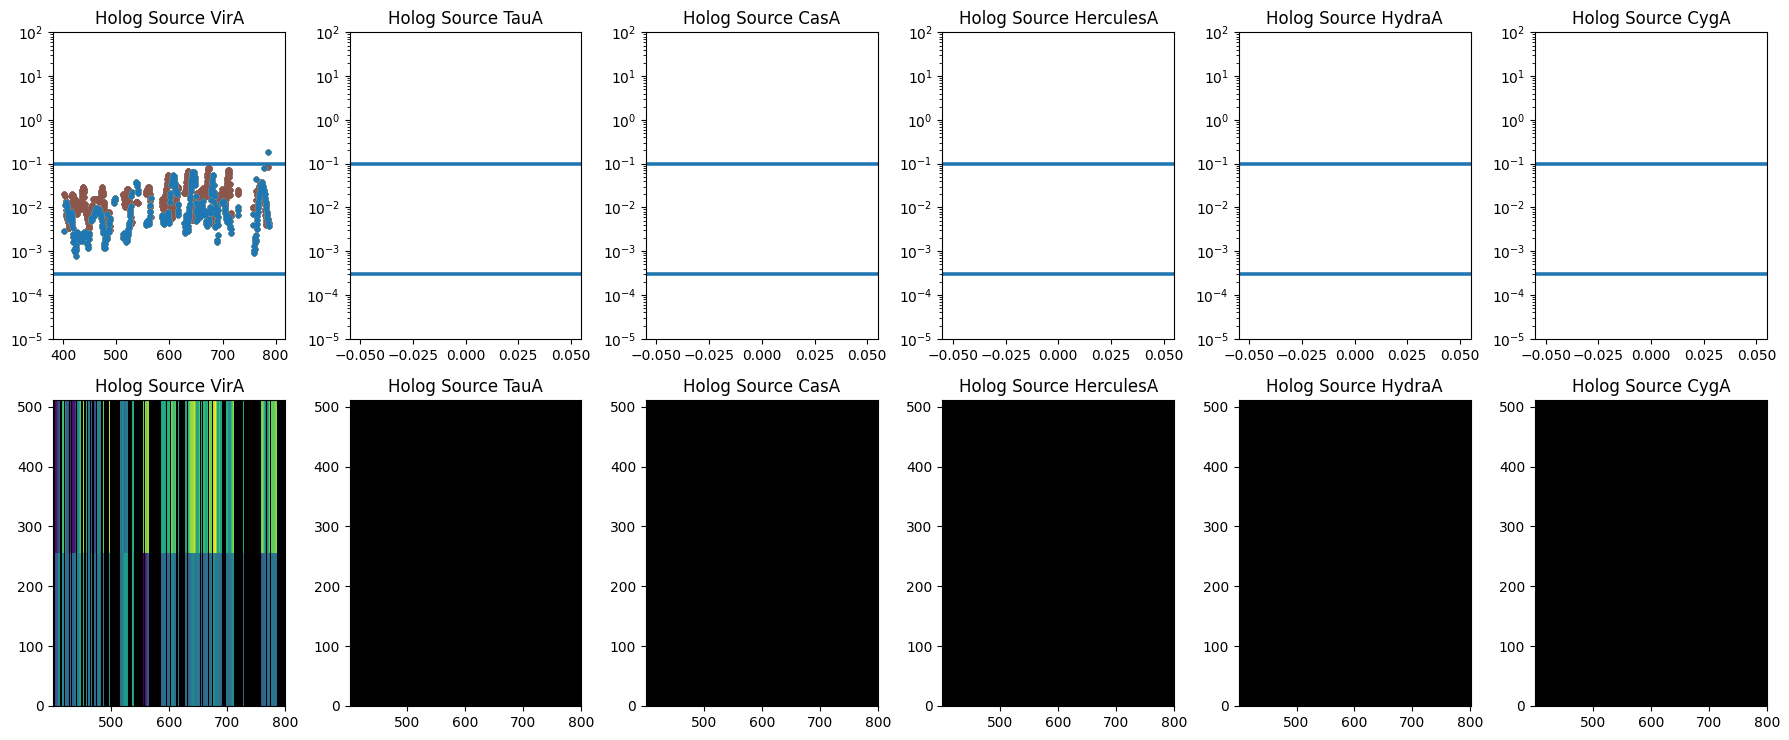

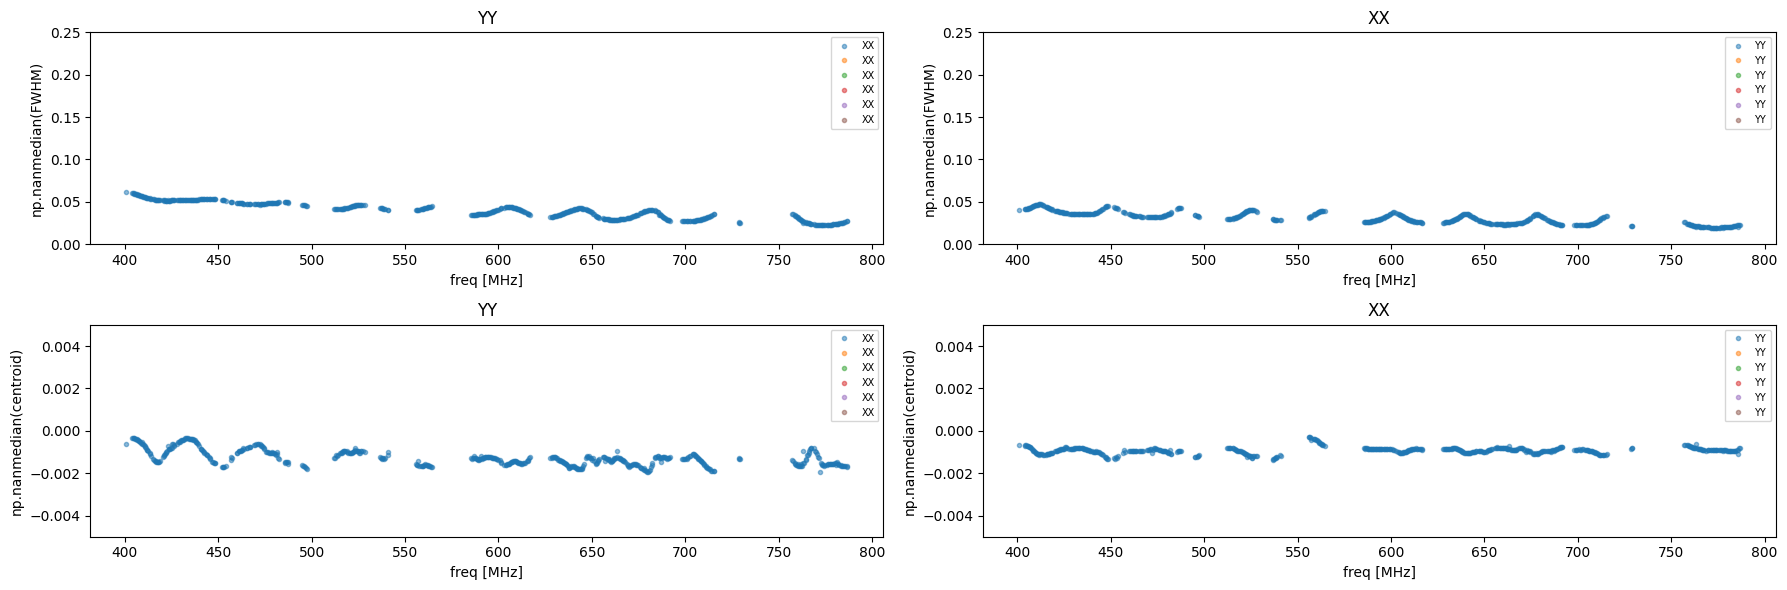

In [14]:
## LOAD Holography Data:
# HologXY=np.load("/home/tyndall/Desktop/holography_all_source_fits_telcoords_with_chisq.npz")
# Hchisqmin,Hchisqmax=[1e-2,1e0] # Old
HologXY=np.load("/home/tyndall/Desktop/CHIME_IEEEpaper/CHIME_paperdata/holo_vira_template_params_with_chisq.npz")
Hchisqmin,Hchisqmax=[3e-4,1e-1] # New (just VirA)
# HologXY=np.load("/home/tyndall/Desktop/holography_power_beam_all_source_fits_telcoords.npz")
# Hchisqmin,Hchisqmax=[3e-4,1e0] # New (just VirA)

Hsources = ["VirA", "TauA", "CasA", "HerculesA", "HydraA", "CygA"]
Hdecs = [12.5,22.0,58.75,5.0,-12.1,40.75] ## New Order
Hdecs = [12.38,22.0,58.75,5.0,-12.1,40.75] ## New Order
Hy,Hx=telescopeCoords(np.outer(np.ones(6),np.linspace(-30,30,1001)),np.outer(np.array(Hdecs),np.ones(1001)))
Hpar_names = ["centroid", "fwhm", "A", "C"]
Hpols = ["YY", "XX"]
Hchisqarr=HologXY['chisq']

Hpoptmask=np.where(np.logical_and(np.repeat((Hchisqarr/HologXY['par'][:,:,:,2])[:,:,:,np.newaxis],4,axis=3)>=Hchisqmin, np.repeat((Hchisqarr/HologXY['par'][:,:,:,2])[:,:,:,np.newaxis],4,axis=3)<=Hchisqmax),HologXY['par'][:,:,:,:],np.nan)
fig,axes=subplots(nrows=2,ncols=6,figsize=(18,7.5))
HologXY['par'][:,:,:,0]
for i,ax in enumerate(axes[0]):
    ax.set_title("Holog Source {}".format(Hsources[i]))
    for Hind in np.arange(0,512,17):
        ax.semilogy(Dfits['Dfreq'],(Hchisqarr[i,:,Hind]/HologXY['par'][i,:,Hind,2]),'.')#,label='chisq theta {:.2f}'.format(Stheta[0]))
        ax.set_ylim(1e-5,1e2)
        ax.axhline(Hchisqmin)
        ax.axhline(Hchisqmax)
#     ax.legend(loc=1)
for i,ax in enumerate(axes[1]):
    ax.set_title("Holog Source {}".format(Hsources[i]))  
    ax.pcolormesh(Dfits['Dfreq'],range(512),np.abs(HologXY['par'][i,:,:,0].T),cmap='gnuplot2')#,aspect='auto')
    ax.pcolormesh(Dfits['Dfreq'],range(512),np.abs(Hpoptmask[i,:,:,0].T))#,norm=LogNorm())#,aspect='auto')
tight_layout()

## close file:
HologXY.close()

## Assign Centroid and FWHM with consistent mapping: YY,XX order in rev3 parameters ==> (XX=[,256:] goes in [0], YY=[,:256] goes in [1])
HologCent=np.nan*np.ones((6,1024,256,2))
HologCent[:,:,:,1]=Hpoptmask[:,:,:256,0]
HologCent[:,:,:,0]=Hpoptmask[:,:,256:,0]
HologFWHM=np.nan*np.ones((6,1024,256,2))
HologFWHM[:,:,:,1]=np.abs(Hpoptmask[:,:,:256,1])
HologFWHM[:,:,:,0]=np.abs(Hpoptmask[:,:,256:,1])

fig,axes=subplots(nrows=2,ncols=2,figsize=(18,6))
for i,source in enumerate(Hsources):
    for j,ax in enumerate(axes[0]):
        ax.plot(Dfits['Dfreq'],np.abs(np.nanmedian(HologFWHM[i,:,:,j],axis=1)),'.',alpha=0.5,label="{}".format(["XX","YY"][j]))
        ax.legend(loc=1,fontsize='x-small')
        ax.set_ylim(0.0,0.25)
        ax.set_title(Hpols[j])
        ax.set_ylabel("np.nanmedian(FWHM)")
        ax.set_xlabel("freq [MHz]")
    for j,ax in enumerate(axes[1]):
        ax.plot(Dfits['Dfreq'],np.nanmedian(HologCent[i,:,:,j],axis=1),'.',alpha=0.5,label="{}".format(["XX","YY"][j]))
        ax.legend(loc=1,fontsize='x-small')
        ax.set_ylim(-0.005,0.005)
        ax.set_title(Hpols[j])
        ax.set_ylabel("np.nanmedian(centroid)")
        ax.set_xlabel("freq [MHz]")
tight_layout()


(-0.020349263553310126, 1330, 38)

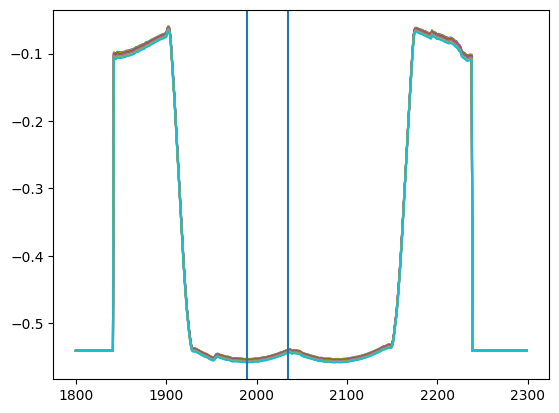

In [15]:
Dfits['telXY_per_feed'].shape,Dfits['Dpoptmask'].shape
Dfits.files
Sfits['Spoptmask'].shape,Sfits['Stheta'].shape

[plot(range(1800,2300),Dfits['telXY_per_feed'][k,1800:2300,1]) for k in range(120,130)]
axvline(1989)
axvline(2035)
Dfits['telXY_per_feed'][165,1989,1]-Dfits['telXY_per_feed'][127,1989,1],35*(165-127),165-127

/home/tyndall/python/beamcals_venv/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1583: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,


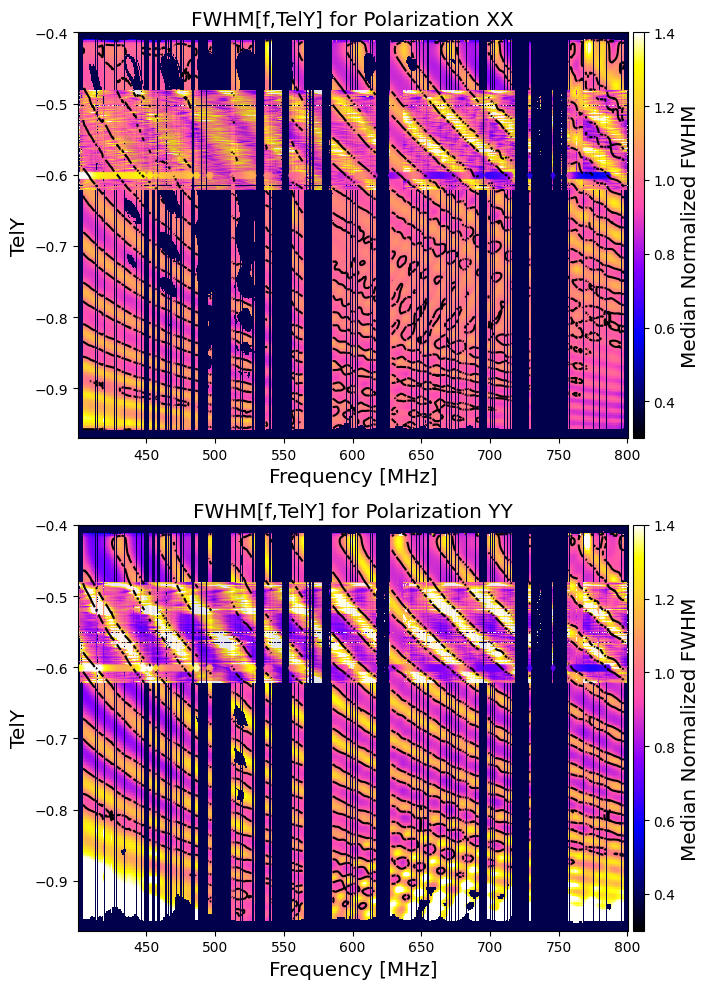

In [16]:
fig,[ax1,ax2]=subplots(nrows=2,ncols=1,figsize=(7.2,10))
for i,ax in enumerate([ax1,ax2]):
    im=ax.pcolormesh(Dfits['Dfreq'],Sfits['Stheta'],(np.abs(Sfits['Spoptmask'])[:,i,:,2]/np.outer(np.nanpercentile(np.abs(Sfits['Spoptmask'])[:,i,:,2],50,axis=1),np.ones(512))).T,cmap='gnuplot2',alpha=1.0,vmin=0.3,vmax=1.4)
    ax.contour(Dfits['Dfreq'],Sfits['Stheta'],(np.abs(Sfits['Spoptmask'])[:,i,:,2]/np.outer(np.nanpercentile(np.abs(Sfits['Spoptmask'])[:,i,:,2],50,axis=1),np.ones(512))).T,levels=[1.0],colors=['k'])
    ax.pcolormesh(Dfits['Dfreq'],Dfits['telXY_per_feed'][0:256,1989,1],(np.abs(Dfits['Dpoptmask'])[:,:,i,2]/np.outer(np.nanpercentile(np.abs(Dfits['Dpoptmask'])[:,:,i,2],50,axis=1),np.ones(256))).T,vmin=0.3,vmax=1.4,cmap='gnuplot2',alpha=0.9)
    ax.set_ylim(-.7,-0.4)
    ax.set_ylim(-.97,-0.4)
#     ax.set_ylim(-1,0.2)
    ax.set_facecolor(colorsarr[20])
    divider=make_axes_locatable(ax)
    cax=divider.append_axes("right", size="2%", pad=0.05)
    cbar=fig.colorbar(im,cax=cax)
    cbar.set_label('Median Normalized FWHM',fontsize='x-large')  
    ax.set_title('FWHM[f,TelY] for Polarization {}'.format(['XX','YY'][i]),fontsize='x-large')
    ax.set_xlabel('Frequency [MHz]',fontsize='x-large')
    ax.set_ylabel('TelY',fontsize='x-large')
    [ax.scatter(Dfits['Dfreq'],Hy[501,j]*np.ones(1024),c=np.nanmedian((HologFWHMPB[j,:,:,i]/np.nanpercentile(HologFWHMPB[j,:,:,i],50,axis=0)),axis=1),s=10,marker='d',vmin=0.3,vmax=1.4,alpha=0.5,cmap='gnuplot2') for j in range(6)[0:1]]
tight_layout()

# savefig("../../Desktop/CHIME_Figures/FWHM_F_TelY_7.png")


Matching Drone Index: 212 --> -0.5990822284238934 -0.6009884342748505
Matching Solar Index: 200 --> -0.6 -0.6009884342748505


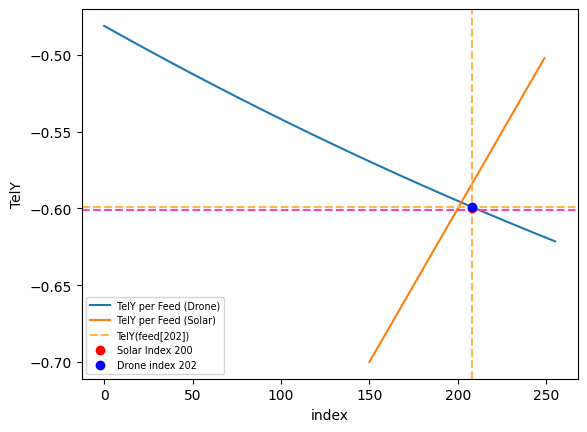

In [17]:
print("Matching Drone Index:",np.abs(Dfits['telXY_per_feed'][:,1989,1]-Hy[501,0]).argmin(),"-->",Dfits['telXY_per_feed'][208,1989,1],Hy[501,0])
print("Matching Solar Index:",np.abs(Sfits['Stheta'][:]-Hy[501,0]).argmin(),"-->",Sfits['Stheta'][200],Hy[501,0])

plot(Dfits['telXY_per_feed'][:256,1989,1],label='TelY per Feed (Drone)')
plot(range(150,250),Sfits['Stheta'][150:250],label='TelY per Feed (Solar)')
axvline(208,linestyle='--',c=colorsarr[208],label="TelY(feed[202])".format(210))
axhline(Hy[501,0],linestyle='--',c=colorsarr[150])
axhline(Dfits['telXY_per_feed'][208,1989,1],linestyle='--',c=colorsarr[210])


plot(208,Sfits['Stheta'][200],'ro',label='Solar Index 200')
plot(208,Dfits['telXY_per_feed'][208,1989,1],'bo',label='Drone index 202')

xlabel('index')
ylabel('TelY')
legend(fontsize='x-small')

In [18]:
# Fitting Loop for Holog PR:
feedshifts=np.arange(0,256)
Pr_arr=np.zeros((6,2,len(feedshifts)))
Pr_av_arr=np.zeros((6,2,len(feedshifts)))
Davg=2
fmin,fmax=[0,800]

# for i in [0,1]:
#     for h in range(6):
#         for k,Dind in enumerate(feedshifts):
#             try:
#                 xav=np.nanmedian(2.335*np.abs(Dfits['Dpoptmask'])[fmin:fmax,Dind-Davg:Dind+Davg,i,2],axis=1)
#                 x=2.335*np.abs(Dfits['Dpoptmask'][fmin:fmax,Dind,i,2])
#                 y=np.nanmean(np.abs(HologFWHMPB[h][fmin:fmax,:,i]),axis=1)
#                 validfinds=np.intersect1d(np.where(~np.isnan(x)==True)[0].tolist(),np.where(~np.isnan(y)==True)[0].tolist()).tolist()
#                 Pr_arr[h,i,k]=pearsonr(x[validfinds],y[validfinds]).statistic
#                 Pr_av_arr[h,i,k]=pearsonr(xav[validfinds],y[validfinds]).statistic
#             except ValueError:
#                 Pr_arr[h,i,k]=np.NAN
#             except TypeError:
#                 pass                 
            
# np.savez("../../Desktop/Holog_PRarr_PowerBeams.npz",\
#         Pr_arr=Pr_arr, Pr_av_arr=Pr_av_arr)

# Fitting Loop for Solar/Holog PR:
# thetashifts=np.arange(0,300)
# SHPr_arr=np.zeros((2,len(thetashifts)))
# fmin,fmax=[0,800]
# fmin,fmax=[0,-1]

# for i in [0,1]:
#     for k,Sind in enumerate(thetashifts):
#         try:
#             x=np.nanmean(np.abs(HologFWHMPB[0][fmin:fmax,:,i]),axis=1)
#             y=2.335*np.abs(Sfits['Spoptmask'][fmin:fmax,i,Sind,2])
#             validfinds=np.intersect1d(np.where(~np.isnan(x)==True)[0].tolist(),np.where(~np.isnan(y)==True)[0].tolist()).tolist()
#             SHPr_arr[i,k]=pearsonr(x[validfinds],y[validfinds]).statistic
#         except ValueError:
#             SHPr_arr[i,k]=np.NAN
            
# np.savez("../../Desktop/Solar_Holog_PRarr_PowerBeams.npz",\
#         SHPr_arr=SHPr_arr)

210
210


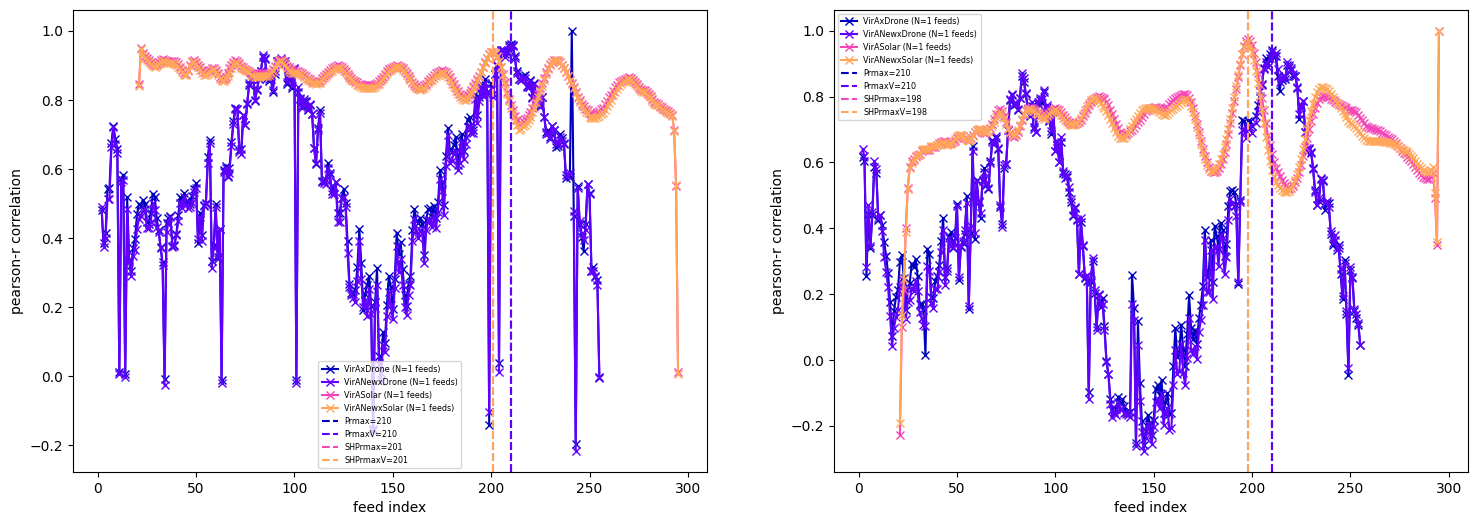

In [19]:
Hologdat=np.load("../../Desktop/CHIME_IEEEpaper/CHIME_paperdata/Holog_PRarr_PowerBeams.npz")
HologdatV=np.load("../../Desktop/CHIME_IEEEpaper/CHIME_paperdata/Holog_PRarr_VirAonly.npz")
SolarHologdat=np.load("../../Desktop/CHIME_IEEEpaper/CHIME_paperdata/Solar_Holog_PRarr_PowerBeams.npz")
SolarHologdatV=np.load("../../Desktop/CHIME_IEEEpaper/CHIME_paperdata/Solar_Holog_PRarr_VirAonly.npz")
feedshifts=np.arange(0,256)
thetashifts=np.arange(0,300)
fig,[ax1,ax2]=subplots(nrows=1,ncols=2,figsize=(18,6))
for i,ax in enumerate([ax1,ax2]):
    #for h in range(6):
    for h in [0]:
        ax.plot(feedshifts,Hologdat['Pr_arr'][h,i,:],'x-',c=colorsarr[50],label='{}xDrone (N=1 feeds)'.format(Hsources[h]))
        ax.plot(feedshifts,HologdatV['Pr_arr'][h,i,:],'x-',c=colorsarr[100],label='{}NewxDrone (N=1 feeds)'.format(Hsources[h]))
        ax.plot(thetashifts,SolarHologdat['SHPr_arr'][i,:],'x-',c=colorsarr[150],label='{}Solar (N=1 feeds)'.format(Hsources[h]))
        ax.plot(thetashifts,SolarHologdatV['SHPr_arr'][i,:],'x-',c=colorsarr[200],label='{}NewxSolar (N=1 feeds)'.format(Hsources[h]))
    Prmax=np.where(Hologdat['Pr_arr'][0,i,:230]==np.nanmax(Hologdat['Pr_arr'][0,i,:230]))[0][0]
    PrmaxV=np.where(HologdatV['Pr_arr'][0,i,:230]==np.nanmax(HologdatV['Pr_arr'][0,i,:230]))[0][0]
    SHPrmax=np.where(SolarHologdat['SHPr_arr'][i,:240]==np.nanmax(SolarHologdat['SHPr_arr'][i,50:240]))[0][0]
    SHPrmaxV=np.where(SolarHologdatV['SHPr_arr'][i,:240]==np.nanmax(SolarHologdatV['SHPr_arr'][i,50:240]))[0][0]
    ax.axvline(Prmax,linestyle='--',c=colorsarr[50],label="Prmax={}".format(Prmax))
    ax.axvline(PrmaxV,linestyle='--',c=colorsarr[100],label="PrmaxV={}".format(PrmaxV))
    ax.axvline(SHPrmax,linestyle='--',c=colorsarr[150],label="SHPrmax={}".format(SHPrmax))
    ax.axvline(SHPrmaxV,linestyle='--',c=colorsarr[200],label="SHPrmaxV={}".format(SHPrmaxV))
    ax.legend(fontsize='xx-small')
    ax.set_xlabel('feed index')
    ax.set_ylabel('pearson-r correlation')
    print(Prmax)
    


In [20]:
## Fitting Loop for Solar PR:
# feedshifts=np.arange(0,256)
# thetashifts=np.arange(0,300)
# sPr_arr=np.zeros((2,len(feedshifts),len(thetashifts)))
# fmin,fmax=[0,800]
# fmin,fmax=[0,-1]

# for i in [0,1]:
#     for j,Dind in enumerate(feedshifts):
#         for k,Sind in enumerate(thetashifts):
#             try:
#                 #x=np.nanmedian(2.335*np.abs(Dfits['Dpoptmask'])[:,Dind-Davg+Doff:Dind+Davg+Doff,i,2],axis=1)
#                 x=2.335*np.abs(Dfits['Dpoptmask'][fmin:fmax,Dind,i,2])
#                 y=2.335*np.abs(Sfits['Spoptmask'][fmin:fmax,i,Sind,2])
#                 validfinds=np.intersect1d(np.where(~np.isnan(x)==True)[0].tolist(),np.where(~np.isnan(y)==True)[0].tolist()).tolist()
#                 sPr_arr[i,j,k]=pearsonr(x[validfinds],y[validfinds]).statistic
#             except ValueError:
#                 sPr_arr[i,j,k]=np.NAN
                
# np.savez("../../Desktop/Solar_PRarr_750cm.npz",\
#         sPr_arr=sPr_arr)

In [22]:
SPRdat=np.load("../../Desktop/CHIME_IEEEpaper/CHIME_paperdata/Solar_PRarr.npz")
SPRdat=np.load("../../Desktop/CHIME_IEEEpaper/CHIME_paperdata/Solar_PRarr_750cm.npz")
feedshifts=np.arange(0,256)
thetashifts=np.arange(0,300)

ctest0=np.load("../../Desktop/CHIME_IEEEpaper/CHIME_paperdata/coords525.npz")
ctest1=np.load("../../Desktop/CHIME_IEEEpaper/CHIME_paperdata/coords530.npz")
ctest2=np.load("../../Desktop/CHIME_IEEEpaper/CHIME_paperdata/coords535.npz")
ctest3=np.load("../../Desktop/CHIME_IEEEpaper/CHIME_paperdata/coords538.npz")
ctest4=np.load("../../Desktop/CHIME_IEEEpaper/CHIME_paperdata/coords540.npz")
ctest5=np.load("../../Desktop/CHIME_IEEEpaper/CHIME_paperdata/coords545.npz")
ctest6=np.load("../../Desktop/CHIME_IEEEpaper/CHIME_paperdata/coords550.npz")
ctest7=np.load("../../Desktop/CHIME_IEEEpaper/CHIME_paperdata/coords555.npz")

sMaxPr=np.zeros((2,len(feedshifts))).astype(int)
sGpoptline=np.zeros((2,2))
sGpoptparab=np.zeros((2,3))
for i in [0,1]:
    for j in feedshifts:
        try:
            maxPRval=np.where(SPRdat['sPr_arr'][i,j,:]==np.nanmax(SPRdat['sPr_arr'][i,j,180:255]))[0][0]
            sMaxPr[i,j]=maxPRval
        except IndexError:
            pass

/tmp/ipykernel_69560/2740721386.py:21: RuntimeWarning: All-NaN slice encountered
  maxPRval=np.where(SPRdat['sPr_arr'][i,j,:]==np.nanmax(SPRdat['sPr_arr'][i,j,180:255]))[0][0]


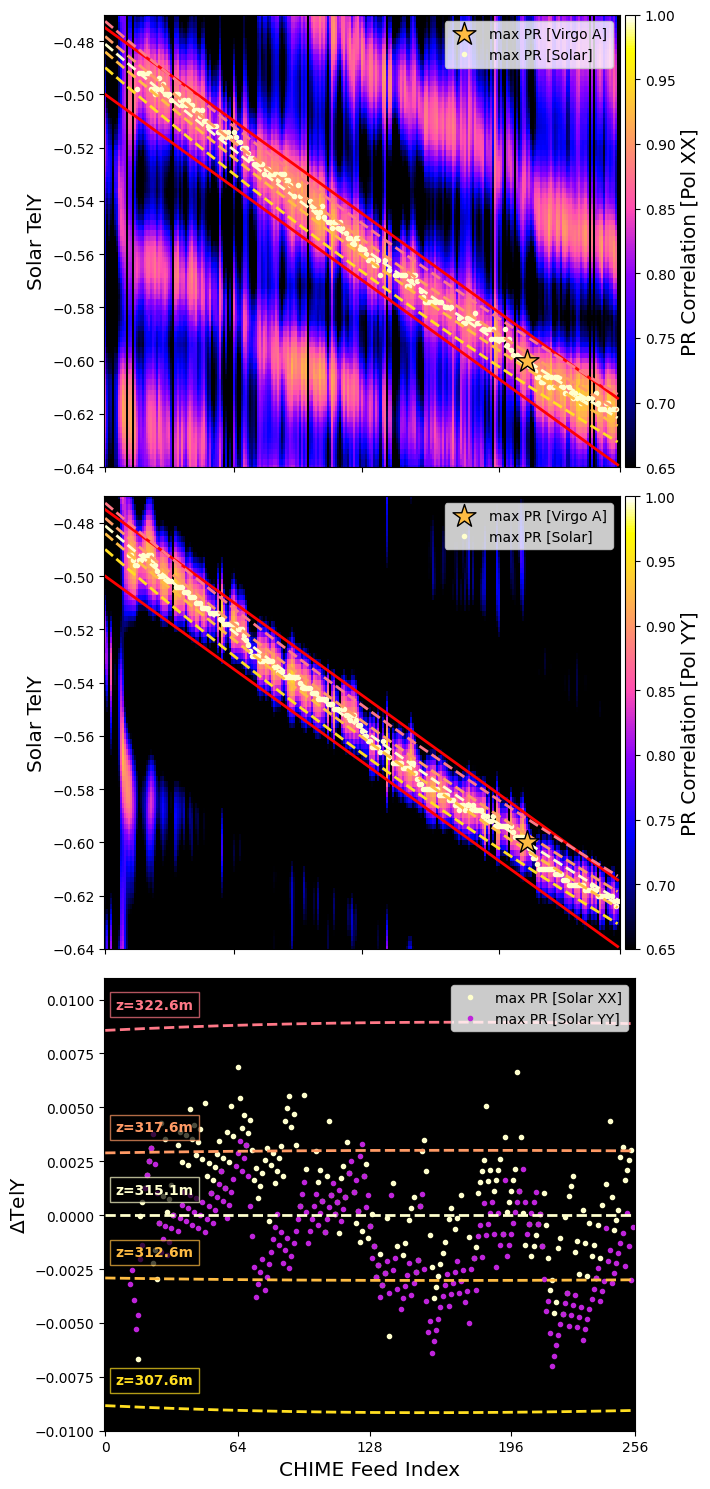

In [443]:
colorsarr=cm.gnuplot2(np.linspace(0,1,256+50))
varcolors=[colorsarr[20],colorsarr[200],colorsarr[220],colorsarr[300],colorsarr[240],colorsarr[260],colorsarr[270],colorsarr[280]]
sprlb,sprub=[-0.500,-0.475]
ctlb,ctub=[1,-2]
fig,[ax1,ax2,ax3]=subplots(nrows=3,ncols=1,figsize=(7.2,15),sharex=True)
for i,ax in enumerate([ax1,ax2]):
    ## Plot Holography PRmax:    
    ax.scatter(210,Sfits['Stheta'][200],color=colorsarr[240],marker='*',s=300,edgecolors='k',linewidth=1,zorder=10,label='max PR [Virgo A]')
    ## Plot Solar PR and add colorbar:
    im=ax.pcolormesh(feedshifts,Sfits['Stheta'][thetashifts],SPRdat['sPr_arr'][i,:,:].T,cmap='gnuplot2',vmin=0.65,vmax=1.0)
    divider=make_axes_locatable(ax)
    cax=divider.append_axes("right", size="2%", pad=0.05)
    cbar=fig.colorbar(im,cax=cax)
    cbar.set_label('PR Correlation [Pol {}]'.format(['XX','YY'][i]),fontsize='x-large')
    ax.set_ylim(-.64,-.47)   
    ## Plot PR Bounds:
    ax.plot(feedshifts,((Sfits['Stheta'][185]-Sfits['Stheta'][245])/220)*feedshifts+sprlb,'r-',linewidth=2)
    ax.plot(feedshifts,((Sfits['Stheta'][185]-Sfits['Stheta'][245])/220)*feedshifts+sprub,'r-',linewidth=2)
    ## Determine sPRmaxmask
    sPRmaxmask=np.where(np.logical_and(Sfits['Stheta'][sMaxPr[i,:]]<=(((Sfits['Stheta'][185]-Sfits['Stheta'][245])/220)*feedshifts+sprub),\
                                       Sfits['Stheta'][sMaxPr[i,:]]>=(((Sfits['Stheta'][185]-Sfits['Stheta'][245])/220)*feedshifts+sprlb)))[0]
    ax.plot(sPRmaxmask,Sfits['Stheta'][sMaxPr[i][sPRmaxmask]],'.',c=colorsarr[300],label='max PR [Solar]')
    ## Plot Residuals in ax3:
    ax3.plot(sPRmaxmask,Sfits['Stheta'][sMaxPr[i][sPRmaxmask]]-Dfits['telXY_per_feed'][:256,1989,1][sPRmaxmask],'.',c=[colorsarr[300],colorsarr[150]][i],label='max PR [Solar {}]'.format(["XX","YY"][i]))   

for j,varct in enumerate([ctest0,ctest1,ctest2,ctest3,ctest4,ctest5,ctest6,ctest7][ctlb:ctub]):
    ax3.plot(feedshifts,varct['telXY_per_feed'][:256,1989,1]-Dfits['telXY_per_feed'][:256,1989,1],'--',c=varcolors[ctlb:ctub][j],linewidth=2.0)
    tx,ty=[feedshifts[0]+5,(varct['telXY_per_feed'][:256,1989,1]-Dfits['telXY_per_feed'][:256,1989,1])[0]+0.001]
    ax3.text(tx,ty,'z={:.1f}m'.format(np.nanmax(varct['zt'])),color=varcolors[ctlb:ctub][j],weight='bold',zorder=10,bbox=dict(facecolor='k', edgecolor=varcolors[ctlb:ctub][j],alpha=0.7))
    for ax in [ax1,ax2]:
        ax.plot(feedshifts,varct['telXY_per_feed'][:256,1989,1],'--',c=varcolors[ctlb:ctub][j],linewidth=2.0)#,label='Altitude: {:.1f}m'.format(np.nanmax(varct['zt'])))

for ax in [ax1,ax2,ax3]:
    ax.set_xticks([0,64,128,196,256])
    ax.set_xticklabels([0,64,128,196,256])
    ax.set_facecolor('k')
    ax.set_ylabel('Solar TelY',fontsize='x-large')
    ax.legend(loc=1,framealpha=0.8)
ax3.set_ylabel('$\Delta$TelY',fontsize='x-large')
ax3.set_ylim(-0.01,0.011)
ax3.set_xlabel('CHIME Feed Index',fontsize='x-large')
fig.tight_layout()

# savefig("../../Desktop/CHIME_Figures/PR_feed_SolarTelY_9.png")


/tmp/ipykernel_69560/2042005387.py:22: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  ax1.pcolormesh(RawDrone['telXY_per_feed'][:,:,0],RawDrone['telXY_per_feed'][:,:,1],np.abs(RawDrone['V']).T/np.nanmax(np.abs(RawDrone['V']).T),cmap='gnuplot2',norm=LogNorm(vmax=1e0,vmin=10e-7))
/tmp/ipykernel_69560/2042005387.py:23: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  ax1.pcolormesh(RawDrone55['za55telXY_per_feed'][:,:,0],RawDrone55['za55telXY_per_feed'][:,:,1],np.abs(RawDrone55['V']).T/np.nanmax(np.abs(RawDrone55['V']).T),cmap='gnuplot2',norm=LogNorm(vmax=1e0,vmin=10e-7))
/tmp/ipykernel_6

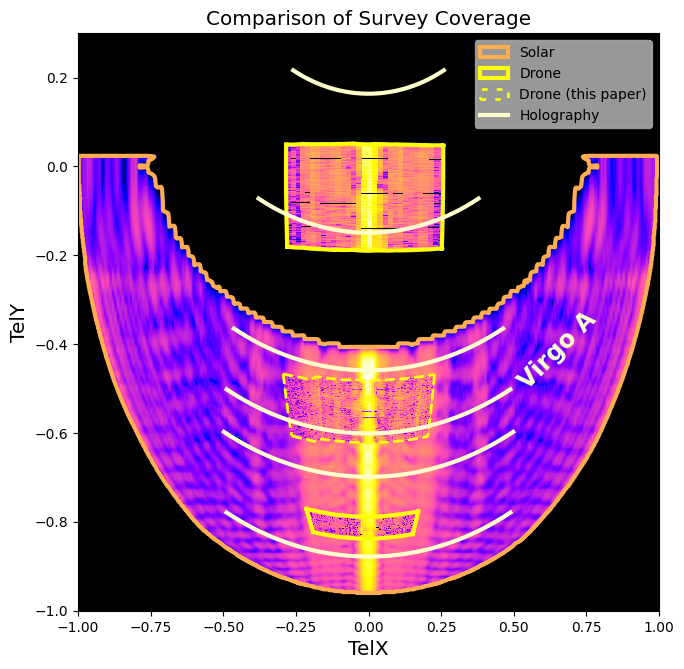

In [444]:
# np.savez("../../Desktop/Solar_Raw_782MHz.npz",\
#         Sb782=Sb[45,0,2,:,:],Sphi=Sphi,Stheta=Stheta)

RawSolar=np.load("../../Desktop/CHIME_IEEEpaper/CHIME_paperdata/Solar_Raw_782MHz.npz")
RawDrone=np.load('../../Desktop/CHIME_IEEEpaper/CHIME_paperdata/Drone_Raw_782MHz.npz')
RawDrone55=np.load('../../Desktop/CHIME_IEEEpaper/CHIME_paperdata/Drone_Raw_782MHz_55deg.npz')
RawDrone0=np.load('../../Desktop/CHIME_IEEEpaper/CHIME_paperdata/Drone_Raw_782MHz_0deg.npz')

fig,ax1=subplots(nrows=1,ncols=1,figsize=(7.5,7.5))
## Plot Solar:
ax1.pcolormesh(RawSolar['Sphi'],RawSolar['Stheta'],np.abs(RawSolar['Sb782'])/np.nanmax(np.abs(RawSolar['Sb782'])),cmap='gnuplot2',norm=LogNorm(vmax=1e0,vmin=10e-7),alpha=1.0)
## Plot Solar Contours:
contourbuffer=np.zeros((513,1001))
contourbuffer[:512,:]=np.abs(RawSolar['Sb782'])/np.nanmax(np.abs(RawSolar['Sb782']))
contourbuffery=np.zeros(513)
contourbuffery[:512]=RawSolar['Stheta']
contourbuffery[512]=np.nanmedian(np.diff(RawSolar['Stheta']))+RawSolar['Stheta'][511]
ax1.contour(RawSolar['Sphi'],contourbuffery,contourbuffer,levels=[0.000001],colors=[colorsarr[230]],linewidths=3)

## Plot Drone:
za0tmax=34
ax1.pcolormesh(RawDrone['telXY_per_feed'][:,:,0],RawDrone['telXY_per_feed'][:,:,1],np.abs(RawDrone['V']).T/np.nanmax(np.abs(RawDrone['V']).T),cmap='gnuplot2',norm=LogNorm(vmax=1e0,vmin=10e-7))
ax1.pcolormesh(RawDrone55['za55telXY_per_feed'][:,:,0],RawDrone55['za55telXY_per_feed'][:,:,1],np.abs(RawDrone55['V']).T/np.nanmax(np.abs(RawDrone55['V']).T),cmap='gnuplot2',norm=LogNorm(vmax=1e0,vmin=10e-7))
ax1.pcolormesh(RawDrone0['za0telXY_per_feed'][:,:za0tmax,0],RawDrone0['za0telXY_per_feed'][:,:za0tmax,1],np.abs(RawDrone0['V'][:za0tmax,:]).T/np.nanmax(np.abs(RawDrone0['V'][:za0tmax,:]).T),cmap='gnuplot2',norm=LogNorm(vmax=1e0,vmin=10e-7))
## Plot Drone Contours:
plot(RawDrone['telXY_per_feed'][0,:,0],RawDrone['telXY_per_feed'][0,:,1],'--',c=colorsarr[280],linewidth=2)
plot(RawDrone['telXY_per_feed'][-1,:,0],RawDrone['telXY_per_feed'][-1,:,1],'--',c=colorsarr[280],linewidth=2)
plot(RawDrone['telXY_per_feed'][:,0,0],RawDrone['telXY_per_feed'][:,0,1],'--',c=colorsarr[280],linewidth=2)
plot(RawDrone['telXY_per_feed'][:,-1,0],RawDrone['telXY_per_feed'][:,-1,1],'--',c=colorsarr[280],linewidth=2)
plot(RawDrone55['za55telXY_per_feed'][0,:,0],RawDrone55['za55telXY_per_feed'][0,:,1],'-',c=colorsarr[280],linewidth=3)
plot(RawDrone55['za55telXY_per_feed'][-1,:,0],RawDrone55['za55telXY_per_feed'][-1,:,1],'-',c=colorsarr[280],linewidth=3)
plot(RawDrone55['za55telXY_per_feed'][:,0,0],RawDrone55['za55telXY_per_feed'][:,0,1],'-',c=colorsarr[280],linewidth=3)
plot(RawDrone55['za55telXY_per_feed'][:,-1,0],RawDrone55['za55telXY_per_feed'][:,-1,1],'-',c=colorsarr[280],linewidth=3)
plot(RawDrone0['za0telXY_per_feed'][0,0:za0tmax,0],RawDrone0['za0telXY_per_feed'][0,0:za0tmax,1],'-',c=colorsarr[280],linewidth=3)
plot(RawDrone0['za0telXY_per_feed'][-1,0:za0tmax,0],RawDrone0['za0telXY_per_feed'][-1,0:za0tmax,1],'-',c=colorsarr[280],linewidth=3)
plot(RawDrone0['za0telXY_per_feed'][:,0,0],RawDrone0['za0telXY_per_feed'][:,0,1],'-',c=colorsarr[280],linewidth=3)
plot(RawDrone0['za0telXY_per_feed'][:,za0tmax,0],RawDrone0['za0telXY_per_feed'][:,za0tmax,1],'-',c=colorsarr[280],linewidth=3)
## Plot Holography:
[ax1.plot(Hx[:,j],Hy[:,j],'-',linewidth=3,c=colorsarr[300]) for j in range(6)]

ax1.set_ylim(-1.0,0.3)
ax1.set_title('Comparison of Survey Coverage',fontsize='x-large')
ax1.set_facecolor('k')
ax1.set_xlabel('TelX',fontsize='x-large')
ax1.set_ylabel('TelY',fontsize='x-large')
ax1.text(0.5,-0.5,"Virgo A",color=colorsarr[300],fontsize='xx-large',weight='bold',rotation=45)
# ax1.set_aspect('equal')
## Legend Labels:
ax1.fill_between([0,0],0,0,linewidth=3,edgecolor=colorsarr[230],facecolor=np.array([0,0,0,0]),label='Solar')
ax1.fill_between([0,0],0,0,linewidth=3,edgecolor=colorsarr[280],facecolor=np.array([0,0,0,0]),label='Drone')
ax1.fill_between([0,0],0,0,linewidth=2,edgecolor=colorsarr[280],linestyle=':',facecolor=np.array([0,0,0,0]),label='Drone (this paper)')

ax1.plot([],[],'-',linewidth=3,c=colorsarr[300],label='Holography')
ax1.legend(loc=1,framealpha=0.6)

# savefig("../../Desktop/CHIME_Figures/Survey_Coverage_6.png")



In [445]:
DYy[210]

-0.6001938007283947

In [446]:
feedind=200
thetaind=np.abs(np.nanmin(RawDrone['telXY_per_feedy'][feedind,:,1])-RawSolar['Stheta']).argmin()
plot(RawSolar['Stheta'])
plot(RawDrone['telXY_per_feedx'][feedind,:,1])
plot(RawDrone['telXY_per_feedy'][feedind,:,1])
plot(len(RawDrone['telXY_per_feedx'][feedind,:,1])/2,np.nanmin(RawDrone['telXY_per_feedx'][feedind,:,1]),'ro')
plot(len(RawDrone['telXY_per_feedy'][feedind,:,1])/2,np.nanmin(RawDrone['telXY_per_feedy'][feedind,:,1]),'ro')
plot((RawDrone['telXY_per_feedy'][:,int(len(RawDrone['telXY_per_feedy'][feedind,:,1])/2),1]))
plot(thetaind,RawSolar['Stheta'][thetaind],'ro')

KeyError: 'telXY_per_feedy is not a file in the archive'

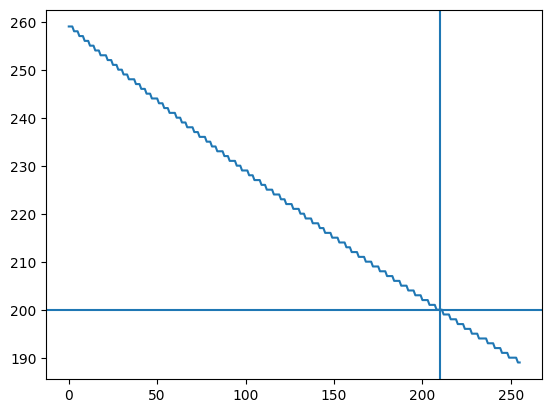

In [447]:
# Fitting Loop for Solar PR:
RawDrone=np.load('../../Desktop/CHIME_IEEEpaper/CHIME_paperdata/Drone_Raw_eigen.npz')
feedshifts=np.arange(0,256)
thetashifts=np.arange(0,300)
SThetaindperDroneFeed=np.zeros(256).astype(int)
for feed in feedshifts:
    SThetaindperDroneFeed[feed]=np.abs(Sfits['Stheta']-RawDrone['telXY_per_feedx'][feed,TelYxminind,1]).argmin()
#     print(feed,RawDrone['telXY_per_feedx'][feed,TelYxminind,1],SThetaindperDroneFeed[feed])

plot(SThetaindperDroneFeed)
axvline(210)
axhline(200)

210 200


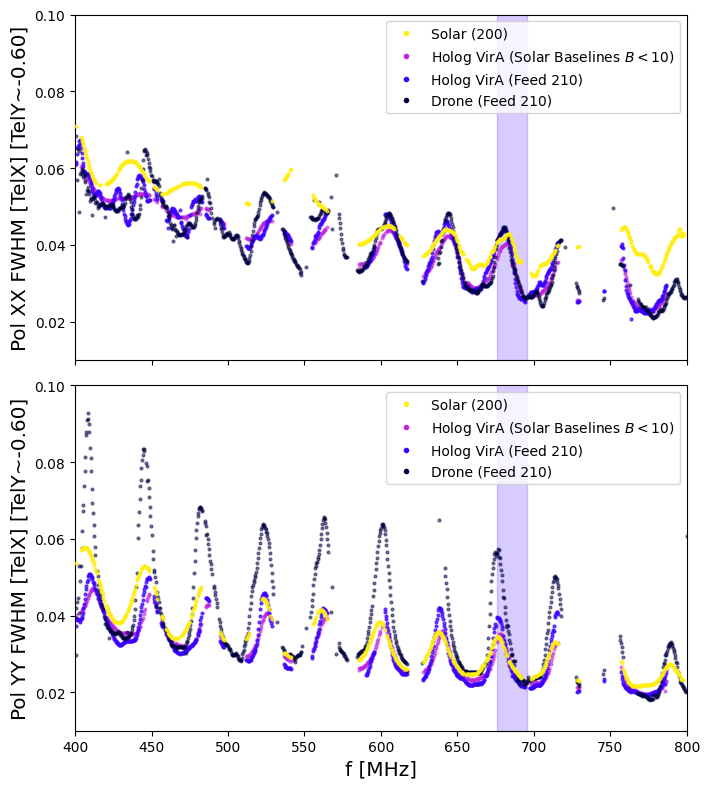

In [453]:
colorsarr=cm.gnuplot2(np.linspace(0,1,256+50))
Davg=3
Savg=1
# for ni,Dind in enumerate(range(207,212)):
for ni,Dind in enumerate([210]):#92
    fig,[ax1,ax2]=subplots(nrows=2,ncols=1,figsize=(7.2,8),sharex=True,sharey=True)
    Sind=SThetaindperDroneFeed[Dind]
    print(Dind,Sind)
    for i,ax in enumerate([ax1,ax2]):
        ## Plot Solar:
        ax.plot(Sfits['Sfreq'],2.335*np.abs(Sfits['Spoptmask'][:,i,Sind,2]),'.',c=colorsarr[270],alpha=0.7,markersize=4,zorder=10)
        ax.plot([],[],'.',c=colorsarr[270],alpha=1,label='Solar ({})'.format(Sind))
        ax.fill_between([Dfits['Dfreq'][fax[0]],Dfits['Dfreq'][fax[-1]]],[0.0,0.0],[0.15,0.15],color=colorsarr[100],alpha=0.2)
        #ax.plot(Sfits['Sfreq'],np.nanmean(2.335*np.abs(Sfits['Spoptmask'][:,i,Sind-Savg:Sind+Savg,2]),axis=1),'.',c=colorsarr[150],alpha=0.7)
        #ax.plot([],[],'.',c=colorsarr[150],alpha=1,label='Solar ({}$\pm${})'.format(Sind,Savg))
        ## Plot Holography:
        [ax.plot(Dfits['Dfreq'],np.abs(HologFWHM[j][:,Dind,i]),'.',c=colorsarr[150],alpha=0.5,markersize=4) for j in [0]]
        [ax.plot([],[],'.',c=colorsarr[150],alpha=1,label="Holog {} (Solar Baselines $B<10$)".format(Hsources[j])) for j in [0]]
        [ax.plot(Dfits['Dfreq'],np.abs(HologFWHMPB[j][:,Dind,i]),'.',c=colorsarr[100],alpha=0.7,markersize=4) for j in [0]]
        [ax.plot([],[],'.',c=colorsarr[100],alpha=1,label="Holog {} (Feed {})".format(Hsources[j],Dind)) for j in [0]]
        #[ax.plot(Dfits['Dfreq'],np.nanmedian(np.abs(HologFWHMPB[j][:,:,i]),axis=1),'.',c=colorsarr[100],alpha=0.5,markersize=4) for j in [0]]
        #[ax.plot([],[],'.',c=colorsarr[100],alpha=1,label="Holog {} (Median of all feeds)".format(Hsources[j])) for j in [0]]
        ## Plot Drone:
        ax.plot(Dfits['Dfreq'],2.335*np.abs(Dfits['Dpoptmask'][:,Dind,i,2]),'.',c=colorsarr[20],alpha=0.5,markersize=4)
        ax.plot([],[],'.',c=colorsarr[20],alpha=1,label='Drone (Feed {})'.format(Dind))
        #ax.plot(Dfits['Dfreq'],2.335*np.nanmean(np.abs(Dfits['Dpoptmask'][:,Dind-Davg:Dind+Davg,i,2]),axis=1),'.',c=colorsarr[50],alpha=0.5)
        #ax.plot([],[],'.',c=colorsarr[50],alpha=1,label='Drone (Feeds {}$\pm${})'.format(Dind,Davg))    
        ## Plot formatting:
        ax.set_ylim(0.01,0.1)
        ax.set_xlim(400,800)
        ax.legend(loc=1)
        #ax.set_title('Pol {} FWHM for feeds [TelY={:.2f}]'.format(Dfits['Dpols'][i],Dfits['telXY_per_feed'][:256,1989,1][Dind]),fontsize='x-large')
        ax2.set_xlabel('f [MHz]',fontsize='x-large')
        ax.set_ylabel('Pol {} FWHM [TelX] [TelY~{:.2f}]'.format(Dfits['Dpols'][i],Dfits['telXY_per_feed'][:256,1989,1][Dind]),fontsize='x-large')
    tight_layout()
#     savefig("../../Desktop/CHIME_Figures/FWHM_Comparison_{}.png".format(ni))
    savefig("../../Desktop/CHIME_IEEEpaper/CHIME_Figures/FWHM_Comparison_PowerBeams_w_inset{}.png".format(ni))


In [36]:
f = np.load("../../Desktop/CHIME_IEEEpaper/CHIME_paperdata/centroid_phydisplace.npz")
cen_var = f['centroid_var'] # the measured beam centroids, in degree
phy_var = f['phydisplace_var'] # the measured feed misalignments, in mm
# cen_var and phy_var are shape (4, 256), first axis is cylinder (so you’ll probably just want index 2 for cyl C) and second axis is feed
Cy,Cx=telescopeCoords(cen_var[2,:],np.zeros(256))
# plot(Cx,range(256),'.')

xxtotalmean=np.nanmedian(Dfits['Dpoptmask'][:,:,0,1])
yytotalmean=np.nanmedian(Dfits['Dpoptmask'][:,:,1,1])

xxcentmean=np.nanmedian(Dfits['Dpoptmask'][:,:,0,1]-xxtotalmean,axis=0)
xxcentmean[np.isnan(xxcentmean)]=0.0
xxcentstd=np.nanstd(Dfits['Dpoptmask'][:,:,0,1]-xxtotalmean)
xxcentn1sig=np.nanpercentile(Dfits['Dpoptmask'][:,:,0,1]-xxtotalmean,50-34.1,axis=0)
xxcentp1sig=np.nanpercentile(Dfits['Dpoptmask'][:,:,0,1]-xxtotalmean,50+34.1,axis=0)
xxcentn2sig=np.nanpercentile(Dfits['Dpoptmask'][:,:,0,1]-xxtotalmean,50-34.1-13.6,axis=0)
xxcentp2sig=np.nanpercentile(Dfits['Dpoptmask'][:,:,0,1]-xxtotalmean,50+34.1+13.6,axis=0)
yycentmean=np.nanmedian(Dfits['Dpoptmask'][:,:,1,1]-yytotalmean,axis=0)
yycentmean[np.isnan(yycentmean)]=0.0
yycentstd=np.nanstd(Dfits['Dpoptmask'][:,:,1,1]-yytotalmean,axis=0)
yycentn1sig=np.nanpercentile(Dfits['Dpoptmask'][:,:,1,1]-yytotalmean,50-34.1,axis=0)
yycentp1sig=np.nanpercentile(Dfits['Dpoptmask'][:,:,1,1]-yytotalmean,50+34.1,axis=0)
yycentn2sig=np.nanpercentile(Dfits['Dpoptmask'][:,:,1,1]-yytotalmean,50-34.1-13.6,axis=0)
yycentp2sig=np.nanpercentile(Dfits['Dpoptmask'][:,:,1,1]-yytotalmean,50+34.1+13.6,axis=0)

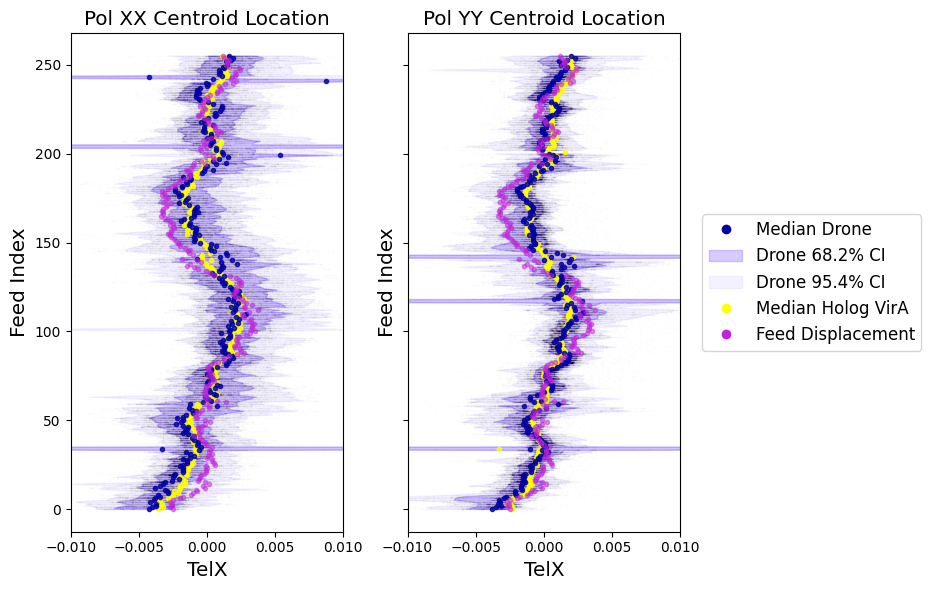

In [37]:
## Easier to read Plot Dimensions:
fig,[ax1,ax2]=subplots(nrows=1,ncols=2,figsize=(7.2,6),sharex=True,sharey=True)
colorsarr=cm.gnuplot2(np.linspace(0,1,256+50))
Davg=2
Savg=1
flb,fub=[0,256]
for ni,indtuple in enumerate([[200,210]]):
    Sind,Dind=indtuple
    for i,ax in enumerate([ax1,ax2]):
        ## Plot all Drone Points:
        ax.plot((Dfits['Dpoptmask'][:,:,i,1]-[xxtotalmean,yytotalmean][i]).flatten(),np.outer(np.ones(1024),range(256)).flatten(),'.',c=colorsarr[20],alpha=0.01,markersize=1)#label='All Drone')
        ## Plot Holography Centroids:
        #for j in [0,1,2,3,4,5]:
        for j in [0]: #just VirA
            ax.plot(np.nanmean((HologCentPB[j][:,:,i]),axis=0)-np.nanmean(HologCentPB[j][:,:,i]),range(256),'.',c=colorsarr[280],markersize=2,alpha=0.2)#,label="All Holog" if j==0 else None) #label="$\Theta_y$={:.2f} : Holog {}".format(Hy[500,j],Hsources[j]))
            ax.plot(np.nanmean(np.nanmean((HologCentPB[:,:,:,i]),axis=1),axis=0)-np.nanmean(HologCentPB[j][:,:,i]),range(256),'.',c=colorsarr[280],alpha=0.8)#,label="Median Holog" if j==0 else None) #label="$\Theta_y$={:.2f} : Holog {}".format(Hy[500,j],Hsources[j]))
        ## Drone Centroids: 
        ax.plot(np.nanmedian((Dfits['Dpoptmask'][:,:,i,1]-[xxtotalmean,yytotalmean][i]),axis=0),range(256),'.',c=colorsarr[50],alpha=0.8)
        ## Median +/- Sigma?
        #A,B=[[xxcentmean-xxcentstd,xxcentmean+xxcentstd],[yycentmean-yycentstd,yycentmean+yycentstd]][i]
        ## Plot Contour Fill: Percentile Cut at 1 Sigma
        A,B=[[xxcentn1sig,xxcentp1sig],[yycentn1sig,yycentp1sig]][i]
        ax.fill_betweenx(range(256),A,B,alpha=0.2,linewidth=1,edgecolor=colorsarr[100],facecolor=colorsarr[100])
        ## Plot Contour Fill: Percentile Cut at 2 Sigma
        A,B=[[xxcentn2sig,xxcentp2sig],[yycentn2sig,yycentp2sig]][i]
        ax.fill_betweenx(range(256),A,B,alpha=0.05,linewidth=1,edgecolor=colorsarr[100],facecolor=colorsarr[100])

for i,ax in enumerate([ax1,ax2]):
    ## Plot DM thesis:
    ax.plot(Cx,range(256),'.',c=colorsarr[150],alpha=0.5)
    ## Legend Stuff:
    #ax.plot([],[],'.',c=colorsarr[20],alpha=1.0,markersize=1,label='All Drone')
    ax.plot([],[],'.',c=colorsarr[50],alpha=1.0,label='Median Drone')
    ## Plot Contour Fill:
    ax.fill_betweenx([],[],[],alpha=0.2,linewidth=1,edgecolor=colorsarr[100],facecolor=colorsarr[100],label='Drone 68.2% CI')
    ax.fill_betweenx([],[],[],alpha=0.05,linewidth=1,edgecolor=colorsarr[100],facecolor=colorsarr[100],label='Drone 95.4% CI')
    ## Plot Holog:
    #ax.plot([],[],'.',c=colorsarr[280],markersize=2,alpha=1.0,label="All Holog VirA")
    ax.plot([],[],'.',c=colorsarr[280],alpha=1.0,label="Median Holog VirA")
    ax.plot([],[],'.',c=colorsarr[150],alpha=1.0,label='Feed Displacement')    
    ax.set_xlim(-0.01,0.01)
    ax.set_title('Pol {} Centroid Location'.format(Dfits['Dpols'][i]),fontsize='x-large')
    ax.set_xlabel('TelX',fontsize='x-large')
    ax.set_ylabel('Feed Index',fontsize='x-large')
tight_layout()
lgd=ax2.legend(loc='center left',bbox_to_anchor=(1.05, 0.5),fontsize='large',facecolor='w',labelcolor='k',framealpha=0.8,markerscale=2)

# fig.savefig("../../Desktop/CHIME_Figures/Centroid_9_PowerBeams.png", bbox_extra_artists=(lgd,), bbox_inches='tight')



205 -0.5979503280413092 201 -0.598


/tmp/ipykernel_69560/1423611722.py:30: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  im1=ax1.pcolormesh(DXxgrid,DYxgrid,(np.abs(EigenDrone['Vx'][:,:,feedind])/np.outer(np.ones(len(DXx)),DNorm[:,0])).T,norm=LogNorm(vmin=5e-3,vmax=1e0),cmap='gnuplot2')
/tmp/ipykernel_69560/1423611722.py:31: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  im2=ax2.pcolormesh(DXygrid,DYygrid,(np.abs(EigenDrone['Vy'][:,:,feedind])/np.outer(np.ones(len(DXy)),DNorm[:,1])).T)
/tmp/ipykernel_69560/1423611722.py:55: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results mig

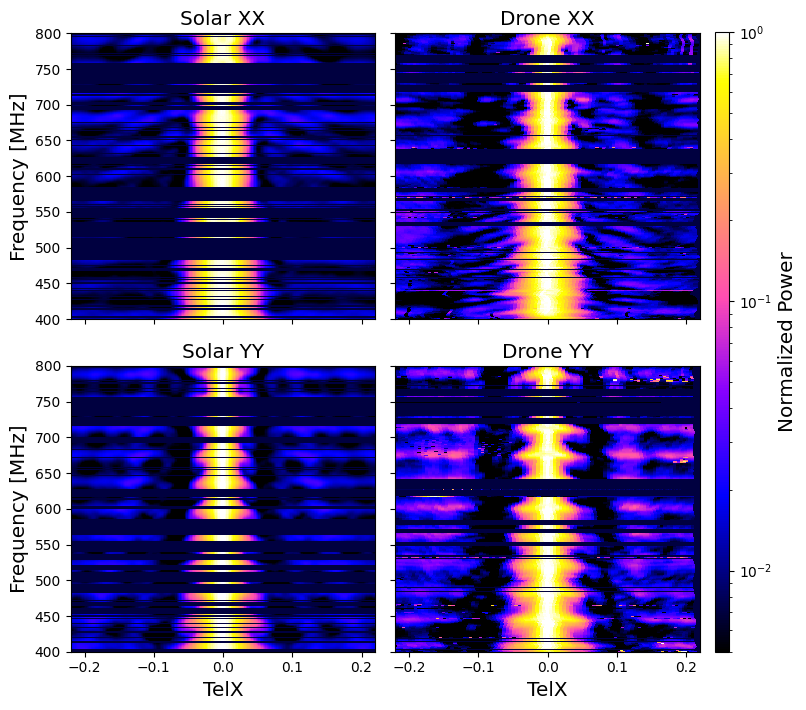

In [38]:
RawSolar=np.load('../../Desktop/CHIME_IEEEpaper/CHIME_paperdata/Solar_Raw_freq_vs_x.npz')
RawDrone=np.load('../../Desktop/CHIME_IEEEpaper/CHIME_paperdata/Drone_Raw.npz')
EigenDrone=np.load('../../Desktop/CHIME_IEEEpaper/CHIME_paperdata/Drone_Raw_eigen.npz')
RawDrone55=np.load('../../Desktop/CHIME_IEEEpaper/CHIME_paperdata/Drone_Raw_55deg.npz')
RawDrone0=np.load('../../Desktop/CHIME_IEEEpaper/CHIME_paperdata/Drone_Raw_0deg.npz')

feedind=205
TelYxminind=np.where((RawDrone['telXY_per_feedx'][feedind,:,1])==np.nanmin(RawDrone['telXY_per_feedx'][feedind,:,1]))[0][0]
TelYyminind=np.where((RawDrone['telXY_per_feedy'][feedind,:,1])==np.nanmin(RawDrone['telXY_per_feedy'][feedind,:,1]))[0][0]
thetaind=np.abs(np.nanmin(RawDrone['telXY_per_feedy'][feedind,:,1])-RawSolar['Stheta']).argmin()
print(feedind,RawDrone['telXY_per_feedx'][feedind,TelYxminind,1],thetaind,RawSolar['Stheta'][thetaind])
## Generate Plot Coordinates:
DXx,DYx=[RawDrone['telXY_per_feedx'][feedind,:,0],Dfits['Dfreq']]
DXy,DYy=[RawDrone['telXY_per_feedy'][feedind,:,0],Dfits['Dfreq']]
xfreqcentcorr=Dfits['Dpoptmask'][:,feedind,0,1]
yfreqcentcorr=Dfits['Dpoptmask'][:,feedind,1,1]
xfreqcentcorr[np.isnan(xfreqcentcorr)]=0.0
yfreqcentcorr[np.isnan(yfreqcentcorr)]=0.0
DXxgrid=np.meshgrid(DXx,DYx)[0]-np.outer(xfreqcentcorr,np.ones(len(DXx)))
DYxgrid=np.meshgrid(DXx,DYx)[1]
DXygrid=np.meshgrid(DXy,DYy)[0]-np.outer(yfreqcentcorr,np.ones(len(DXy)))
DYygrid=np.meshgrid(DXy,DYy)[1]
SX,SY=[RawSolar['Sphi'],Dfits['Dfreq']]
## Generate Normalization from fits:
DNorm=(Dfits['Dpoptmask'][:,feedind,:,0]+Dfits['Dpoptmask'][:,feedind,:,3])
SNorm=(Sfits['Spoptmask'][:,:,thetaind,0]+Sfits['Spoptmask'][:,:,thetaind,3])

## Plot 4 Eigenmode 0 images:
fig,[[ax3,ax1],[ax4,ax2]]=subplots(nrows=2,ncols=2,figsize=(7.2,7.2),sharex=True,sharey=True)
im1=ax1.pcolormesh(DXxgrid,DYxgrid,(np.abs(EigenDrone['Vx'][:,:,feedind])/np.outer(np.ones(len(DXx)),DNorm[:,0])).T,norm=LogNorm(vmin=5e-3,vmax=1e0),cmap='gnuplot2')
im2=ax2.pcolormesh(DXygrid,DYygrid,(np.abs(EigenDrone['Vy'][:,:,feedind])/np.outer(np.ones(len(DXy)),DNorm[:,1])).T)
im3=ax3.pcolormesh(SX,SY,(np.abs(RawSolar['Sbx'][:,thetaind,:])/np.outer(SNorm[:,0],np.ones(len(SX)))))
im4=ax4.pcolormesh(SX,SY,(np.abs(RawSolar['Sby'][:,thetaind,:])/np.outer(SNorm[:,1],np.ones(len(SX)))))
images=[im1,im2,im3,im4]

for i,ax in enumerate([ax1,ax2,ax3,ax4]):
    images[i].set_norm(LogNorm(vmin=5e-3,vmax=1e0))
    images[i].set_cmap('gnuplot2')
    ax.set_facecolor(colorsarr[20])
    ax.set_xlim(-0.22,0.22)
    ax.set_title("{}".format(["Drone XX","Drone YY","Solar XX","Solar YY"][i]),fontsize='x-large')
    ax.set_xlabel("TelX" if i in [1,3] else None,fontsize='x-large')
    ax.set_ylabel("Frequency [MHz]" if i in [2,3] else None,fontsize='x-large')
    ## Don't want 4 cbars if same colorscale...
    #divider=make_axes_locatable(ax)
    #cax=divider.append_axes("right", size="2%", pad=0.05)
    #cbar=fig.colorbar(images[i],cax=cax)
    #cbar.set_label('Normalized Power',fontsize='x-large')
    ax.set_ylim(400,800)
fig.tight_layout()
## Rather have only one colorbar:
cbar_ax=fig.add_axes([1.0, 0.08788, 0.02, 0.861])
cbar=fig.colorbar(im1, cax=cbar_ax)
cbar.set_label('Normalized Power',fontsize='x-large')
fig.tight_layout()

# savefig("../../Desktop/CHIME_Figures/Waterfall_TelX_f_feed205_2.png")


0 -0.4815896316120326 259 -0.482
690.625 689.84375


/tmp/ipykernel_69560/4057718497.py:32: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  im1=ax1.pcolormesh(EigenDrone['telXY_per_feedx'][:,:,0],EigenDrone['telXY_per_feedx'][:,:,1],(np.nanmedian(np.abs(EigenDrone['Vx'][:,flb:fub,:]),axis=1)/np.outer(np.ones(len(DXx)),DNorm[:,0])).T)
/tmp/ipykernel_69560/4057718497.py:33: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  im2=ax2.pcolormesh(EigenDrone['telXY_per_feedy'][:,:,0],EigenDrone['telXY_per_feedy'][:,:,1],(np.nanmedian(np.abs(EigenDrone['Vy'][:,flb:fub,:]),axis=1)/np.outer(np.ones(len(DXy)),DNorm[:,1])).T)
/tmp/ipykernel_69560/40577

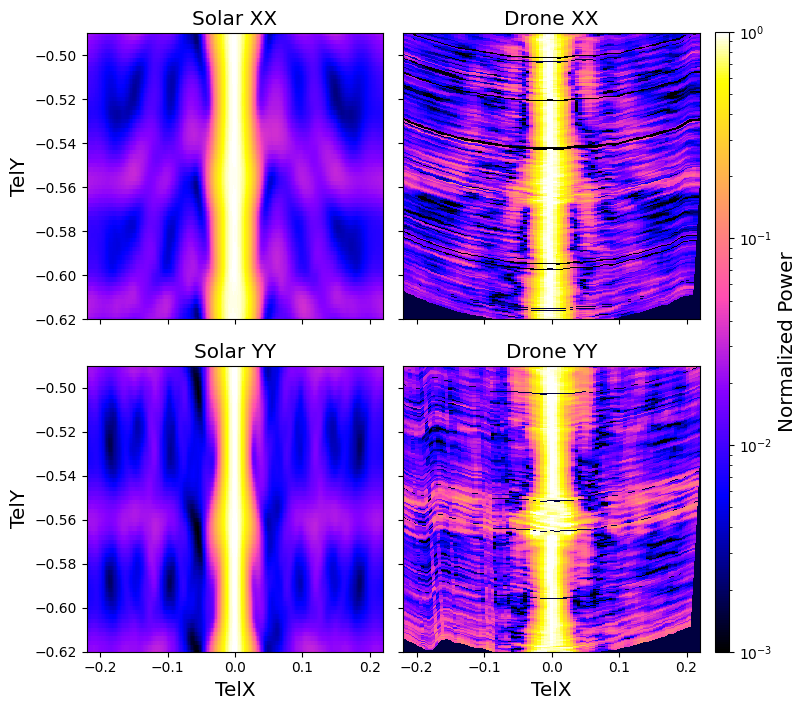

In [39]:
feedind=0
TelYxminind=np.where((RawDrone['telXY_per_feedx'][feedind,:,1])==np.nanmin(RawDrone['telXY_per_feedx'][feedind,:,1]))[0][0]
TelYyminind=np.where((RawDrone['telXY_per_feedy'][feedind,:,1])==np.nanmin(RawDrone['telXY_per_feedy'][feedind,:,1]))[0][0]
thetaind=np.abs(np.nanmin(RawDrone['telXY_per_feedy'][feedind,:,1])-RawSolar['Stheta']).argmin()
print(feedind,RawDrone['telXY_per_feedx'][feedind,TelYxminind,1],thetaind,RawSolar['Stheta'][thetaind])
## Generate Plot Coordinates:
flb,fub=[45,46]
# flb,fub=[77,78]
flb,fub=[280,282]
# flb,fub=[536,537]
DXx,DYx=[RawDrone['telXY_per_feedx'][feedind,:,0],RawDrone['telXY_per_feedx'][:,TelYxminind,1]]
DXxgrid=np.meshgrid(DXx,DYx)[0]-np.outer(xxcentmean,np.ones(len(DXx)))
DYxgrid=np.meshgrid(DXx,DYx)[1]
DXy,DYy=[RawDrone['telXY_per_feedy'][feedind,:,0],RawDrone['telXY_per_feedy'][:,TelYyminind,1]]
DXygrid=np.meshgrid(DXy,DYy)[0]-np.outer(yycentmean,np.ones(len(DXy)))
DYygrid=np.meshgrid(DXy,DYy)[1]
SX,SY=[RawSolar['Sphi'],RawSolar['Stheta']]
## Generate Normalization from fits:
DNorm=(Dfits['Dpoptmask'][flb,:,:300,0]+Dfits['Dpoptmask'][flb,:,:300,3])
SNorm=(Sfits['Spoptmask'][flb,:,:300,0]+Sfits['Spoptmask'][flb,:,:300,3])
print(Dfits['Dfreq'][flb],Dfits['Dfreq'][fub])
conts=[0.6,0.9]
contcols=['k','k']

fig,[[ax3,ax1],[ax4,ax2]]=subplots(nrows=2,ncols=2,figsize=(7.2,7.2),sharex=True,sharey=True)
# im1=ax1.contour(DXxgrid,DYxgrid,(np.nanmedian(np.abs(EigenDrone['Vx'][:,flb:fub,:]),axis=1)/np.outer(np.ones(len(DXx)),DNorm[:,0])).T,levels=conts,colors=contcols)
# im2=ax2.contour(DXygrid,DYygrid,(np.nanmedian(np.abs(EigenDrone['Vy'][:,flb:fub,:]),axis=1)/np.outer(np.ones(len(DXy)),DNorm[:,1])).T,levels=conts,colors=contcols)
# im3=ax3.contour(SX,SY,(np.nanmedian(np.abs(RawSolar['Sbx'][flb:fub,:,:]),axis=0)/np.outer(SNorm[0,:],np.ones(len(SX)))),levels=conts,colors=contcols)
# im4=ax4.contour(SX,SY,(np.nanmedian(np.abs(RawSolar['Sby'][flb:fub,:,:]),axis=0)/np.outer(SNorm[1,:],np.ones(len(SX)))),levels=conts,colors=contcols)
# im1=ax1.pcolormesh(DXxgrid,DYxgrid,(np.nanmedian(np.abs(EigenDrone['Vx'][:,flb:fub,:]),axis=1)/np.outer(np.ones(len(DXx)),DNorm[:,0])).T)
# im2=ax2.pcolormesh(DXygrid,DYygrid,(np.nanmedian(np.abs(EigenDrone['Vy'][:,flb:fub,:]),axis=1)/np.outer(np.ones(len(DXy)),DNorm[:,1])).T)
im1=ax1.pcolormesh(EigenDrone['telXY_per_feedx'][:,:,0],EigenDrone['telXY_per_feedx'][:,:,1],(np.nanmedian(np.abs(EigenDrone['Vx'][:,flb:fub,:]),axis=1)/np.outer(np.ones(len(DXx)),DNorm[:,0])).T)
im2=ax2.pcolormesh(EigenDrone['telXY_per_feedy'][:,:,0],EigenDrone['telXY_per_feedy'][:,:,1],(np.nanmedian(np.abs(EigenDrone['Vy'][:,flb:fub,:]),axis=1)/np.outer(np.ones(len(DXy)),DNorm[:,1])).T)
im3=ax3.pcolormesh(SX,SY,(np.nanmedian(np.abs(RawSolar['Sbx'][flb:fub,:,:]),axis=0)/np.outer(SNorm[0,:],np.ones(len(SX)))))
im4=ax4.pcolormesh(SX,SY,(np.nanmedian(np.abs(RawSolar['Sby'][flb:fub,:,:]),axis=0)/np.outer(SNorm[1,:],np.ones(len(SX)))))
images=[im1,im2,im3,im4]
for i,ax in enumerate([ax1,ax2,ax3,ax4]):
    images[i].set_cmap('gnuplot2')
    images[i].set_norm(LogNorm(vmin=1e-3,vmax=1e0))
#     images[i].set_clim(0.0,1.0)
    ax.set_facecolor(colorsarr[20])
    ax.set_title("{}".format(["Drone XX","Drone YY","Solar XX","Solar YY"][i]),fontsize='x-large')
    #divider=make_axes_locatable(ax)
    #cax=divider.append_axes("right", size="5%", pad=0.05)
    #cbar=fig.colorbar(images[i],cax=cax)
    #cbar.set_label('Normalized Power',fontsize='x-large')
    ax.set_xlim(-0.22,0.22)
    ax.set_ylim(-0.62,-.49)
    ax.set_xlabel("TelX" if i in [1,3] else None,fontsize='x-large')
    ax.set_ylabel("TelY" if i in [2,3] else None,fontsize='x-large')
tight_layout()
cbar_ax=fig.add_axes([1.0, 0.08788, 0.02, 0.861])
cbar=fig.colorbar(im1, cax=cbar_ax)
cbar.set_label('Normalized Power',fontsize='x-large')
fig.tight_layout()

# savefig("../../Desktop/CHIME_Figures/Waterfall_TelX_TelY_690MHz_3.png")


13.155075727417731 -0.5901143744866225


/tmp/ipykernel_69560/1211488168.py:17: RuntimeWarning: All-NaN axis encountered
  ax.plot(RawDrone['telXY_per_feed{}'.format(['x','y'][i])][feed,:,0],RawDrone['V{}'.format(['x','y'][i])][:,ff,feed]/np.nanmax(Dfits['Dpoptmask'][ff,feed,i,0]),'.-',c=colorsarr[ff],alpha=1,label='{:.2f} MHz'.format(Dfits['Dfreq'][ff]))
/tmp/ipykernel_69560/1211488168.py:19: RuntimeWarning: All-NaN axis encountered
  ax.plot(synthX,fu.Gauss(synthX,*Dfits['Dpoptmask'][ff,feed,i,:])/np.nanmax(Dfits['Dpoptmask'][ff,feed,i,0]),':',linewidth=2,c=colorsarr[ff],alpha=0.5)


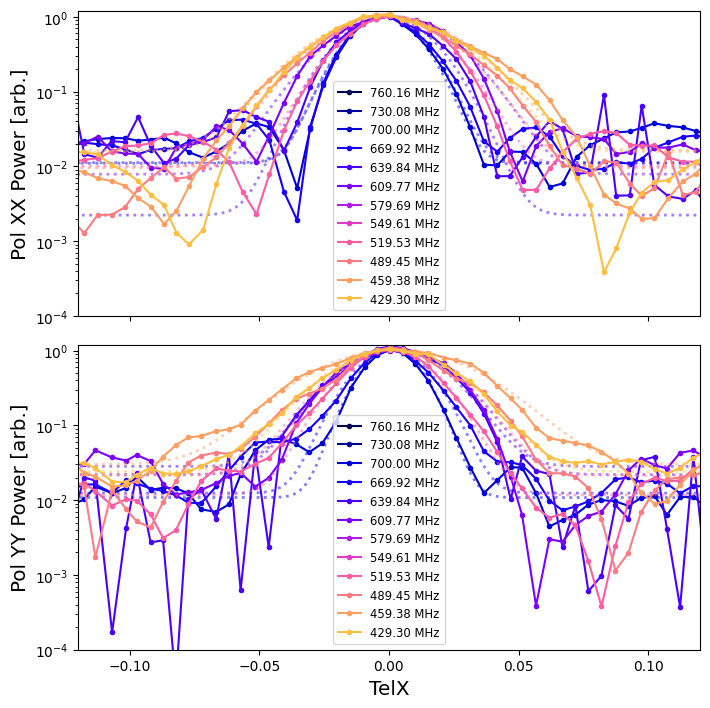

In [118]:
RawDrone=np.load('../../Desktop/CHIME_IEEEpaper/CHIME_paperdata/Drone_Raw_eigen.npz')
# RawDrone=np.load('../../Desktop/Drone_Raw.npz')
#what TelY and Dec are shown here?
print(Dcoords['RA_Dec_per_feed'][190,1989,1],Dcoords['telXY_per_feed'][190,1989,1])

colorsarr=cm.gnuplot2(np.linspace(0,1,1200))
fig,[ax1,ax2]=subplots(nrows=2,ncols=1,figsize=(7.2,7.2),sharex=True,sharey=True)
# for pol,tbds in enumerate([[2044,2148],[1933,2035]]):
#     ax1,ax2=axes[pol]
#     tlb,tub=tbds
#     for ff in ([78,660]):
for ff in np.arange(64+38,1024,77):#(np.array([64,256,512,960])):
    ## add legend labels for *first* feed only:
#         for feed in (np.array([4])):
    for feed in (np.array([92])):#210
        for i,ax in enumerate([ax1,ax2]):
            ax.plot(RawDrone['telXY_per_feed{}'.format(['x','y'][i])][feed,:,0],RawDrone['V{}'.format(['x','y'][i])][:,ff,feed]/np.nanmax(Dfits['Dpoptmask'][ff,feed,i,0]),'.-',c=colorsarr[ff],alpha=1,label='{:.2f} MHz'.format(Dfits['Dfreq'][ff]))
            synthX=np.linspace(RawDrone['telXY_per_feed{}'.format(['x','y'][i])][feed,0,0],RawDrone['telXY_per_feed{}'.format(['x','y'][i])][feed,-1,0],1000)
            ax.plot(synthX,fu.Gauss(synthX,*Dfits['Dpoptmask'][ff,feed,i,:])/np.nanmax(Dfits['Dpoptmask'][ff,feed,i,0]),':',linewidth=2,c=colorsarr[ff],alpha=0.5)
#             print(np.nanmax(Dfits['Dpoptmask'][ff,feed,i,3]))
#             print(np.nanmin(RawDrone['telXY_per_feed{}'.format(['x','y'][i])][feed,:,1]))

    for j,ax in enumerate([ax1,ax2]):
#         ax.set_facecolor('k')
#         ax.grid()
        ax.semilogy()
        ax.set_xlim(-0.12,0.12)
        ax.set_ylim(1e-4,1.2e0)
        ax.set_xlabel('TelX' if j==1 else None,fontsize='x-large')
        ax.set_ylabel('Pol {} Power [arb.]'.format(['XX','YY'][j]),fontsize='x-large')
#         ax.legend(loc=8,fontsize='large')
        ax.legend(loc=8,fontsize='small')
tight_layout()
        
# fig.savefig("../../Desktop/CHIME_Figures/Gauss_1d_slice.png")


13.155075727417731 -0.5901143744866225


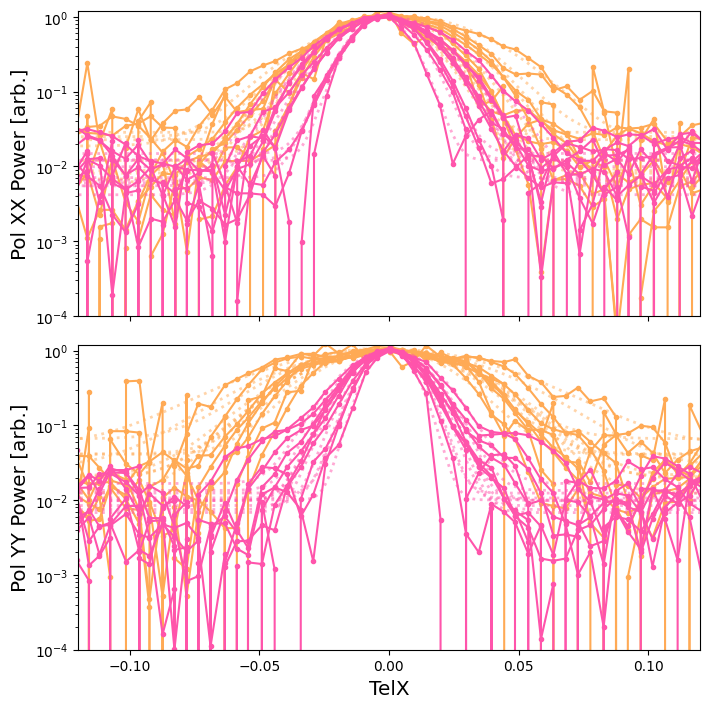

In [342]:
RawDrone=np.load('../../Desktop/CHIME_IEEEpaper/CHIME_paperdata/Drone_Raw_eigen.npz')
# RawDrone=np.load('../../Desktop/Drone_Raw.npz')
#what TelY and Dec are shown here?
print(Dcoords['RA_Dec_per_feed'][190,1989,1],Dcoords['telXY_per_feed'][190,1989,1])

colorsarr=cm.gnuplot2(np.linspace(0,1,1200))
fig,[ax1,ax2]=subplots(nrows=2,ncols=1,figsize=(7.2,7.2),sharex=True,sharey=True)
# for pol,tbds in enumerate([[2044,2148],[1933,2035]]):
#     ax1,ax2=axes[pol]
#     tlb,tub=tbds
#     for ff in ([78,660]):
for ff in peaks:#(np.array([64,256,512,960])):
    for feed in (np.array([210])):#210
        for i,ax in enumerate([ax1,ax2]):
            ax.plot(RawDrone['telXY_per_feed{}'.format(['x','y'][i])][feed,:,0],RawDrone['V{}'.format(['x','y'][i])][:,ff,feed]/np.nanmax(Dfits['Dpoptmask'][ff,feed,i,0]),'.-',c=colorsarr[900],alpha=1,label='{:.2f} MHz'.format(Dfits['Dfreq'][ff]))
            synthX=np.linspace(RawDrone['telXY_per_feed{}'.format(['x','y'][i])][feed,0,0],RawDrone['telXY_per_feed{}'.format(['x','y'][i])][feed,-1,0],1000)
            ax.plot(synthX,fu.Gauss(synthX,*Dfits['Dpoptmask'][ff,feed,i,:])/np.nanmax(Dfits['Dpoptmask'][ff,feed,i,0]),':',linewidth=2,c=colorsarr[900],alpha=0.5)

for ff in troughs:#(np.array([64,256,512,960])):
    for feed in (np.array([210])):#210
        for i,ax in enumerate([ax1,ax2]):
            ax.plot(RawDrone['telXY_per_feed{}'.format(['x','y'][i])][feed,:,0],RawDrone['V{}'.format(['x','y'][i])][:,ff,feed]/np.nanmax(Dfits['Dpoptmask'][ff,feed,i,0]),'.-',c=colorsarr[700],alpha=1,label='{:.2f} MHz'.format(Dfits['Dfreq'][ff]))
            synthX=np.linspace(RawDrone['telXY_per_feed{}'.format(['x','y'][i])][feed,0,0],RawDrone['telXY_per_feed{}'.format(['x','y'][i])][feed,-1,0],1000)
            ax.plot(synthX,fu.Gauss(synthX,*Dfits['Dpoptmask'][ff,feed,i,:])/np.nanmax(Dfits['Dpoptmask'][ff,feed,i,0]),':',linewidth=2,c=colorsarr[700],alpha=0.5)

    for j,ax in enumerate([ax1,ax2]):
#         ax.set_facecolor('k')
#         ax.grid()
        ax.semilogy()
        ax.set_xlim(-0.12,0.12)
        ax.set_ylim(1e-4,1.2e0)
        ax.set_xlabel('TelX' if j==1 else None,fontsize='x-large')
        ax.set_ylabel('Pol {} Power [arb.]'.format(['XX','YY'][j]),fontsize='x-large')
#         ax.legend(loc=8,fontsize='large')
#         ax.legend(loc=1,fontsize='small')
tight_layout()
        
# fig.savefig("../../Desktop/CHIME_Figures/Gauss_1d_slice.png")


13.155075727417731 -0.5901143744866225


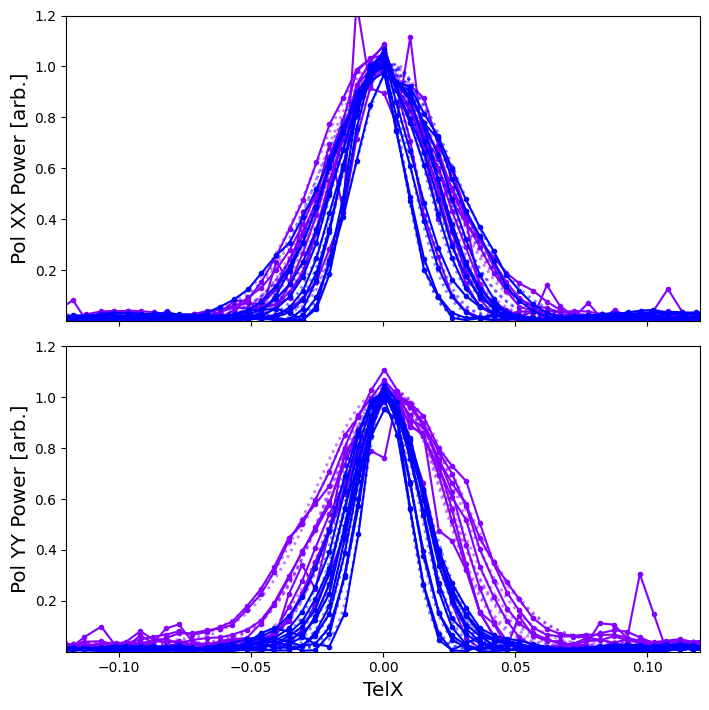

In [345]:
RawDrone=np.load('../../Desktop/CHIME_IEEEpaper/CHIME_paperdata/Drone_Raw_eigen.npz')
# RawDrone=np.load('../../Desktop/Drone_Raw.npz')
#what TelY and Dec are shown here?
print(Dcoords['RA_Dec_per_feed'][190,1989,1],Dcoords['telXY_per_feed'][190,1989,1])

colorsarr=cm.gnuplot2(np.linspace(0,1,1200))
fig,[ax1,ax2]=subplots(nrows=2,ncols=1,figsize=(7.2,7.2),sharex=True,sharey=True)

for ff in peaks2:#(np.array([64,256,512,960])):
    for feed in (np.array([92])):#210
        for i,ax in enumerate([ax1,ax2]):
            ax.plot(RawDrone['telXY_per_feed{}'.format(['x','y'][i])][feed,:,0],RawDrone['V{}'.format(['x','y'][i])][:,ff,feed]/np.nanmax(Dfits['Dpoptmask'][ff,feed,i,0]),'.-',c=colorsarr[500],alpha=1,label='{:.2f} MHz'.format(Dfits['Dfreq'][ff]))
            synthX=np.linspace(RawDrone['telXY_per_feed{}'.format(['x','y'][i])][feed,0,0],RawDrone['telXY_per_feed{}'.format(['x','y'][i])][feed,-1,0],1000)
            ax.plot(synthX,fu.Gauss(synthX,*Dfits['Dpoptmask'][ff,feed,i,:])/np.nanmax(Dfits['Dpoptmask'][ff,feed,i,0]),':',linewidth=2,c=colorsarr[500],alpha=0.5)
            
for ff in troughs2:#(np.array([64,256,512,960])):
    for feed in (np.array([92])):#210
        for i,ax in enumerate([ax1,ax2]):
            ax.plot(RawDrone['telXY_per_feed{}'.format(['x','y'][i])][feed,:,0],RawDrone['V{}'.format(['x','y'][i])][:,ff,feed]/np.nanmax(Dfits['Dpoptmask'][ff,feed,i,0]),'.-',c=colorsarr[300],alpha=1,label='{:.2f} MHz'.format(Dfits['Dfreq'][ff]))
            synthX=np.linspace(RawDrone['telXY_per_feed{}'.format(['x','y'][i])][feed,0,0],RawDrone['telXY_per_feed{}'.format(['x','y'][i])][feed,-1,0],1000)
            ax.plot(synthX,fu.Gauss(synthX,*Dfits['Dpoptmask'][ff,feed,i,:])/np.nanmax(Dfits['Dpoptmask'][ff,feed,i,0]),':',linewidth=2,c=colorsarr[300],alpha=0.5)


    for j,ax in enumerate([ax1,ax2]):
#         ax.set_facecolor('k')
#         ax.grid()
#         ax.semilogy()
        ax.set_xlim(-0.12,0.12)
        ax.set_ylim(1e-4,1.2e0)
        ax.set_xlabel('TelX' if j==1 else None,fontsize='x-large')
        ax.set_ylabel('Pol {} Power [arb.]'.format(['XX','YY'][j]),fontsize='x-large')
#         ax.legend(loc=8,fontsize='large')
#         ax.legend(loc=1,fontsize='small')
tight_layout()
        
# fig.savefig("../../Desktop/CHIME_Figures/Gauss_1d_slice.png")


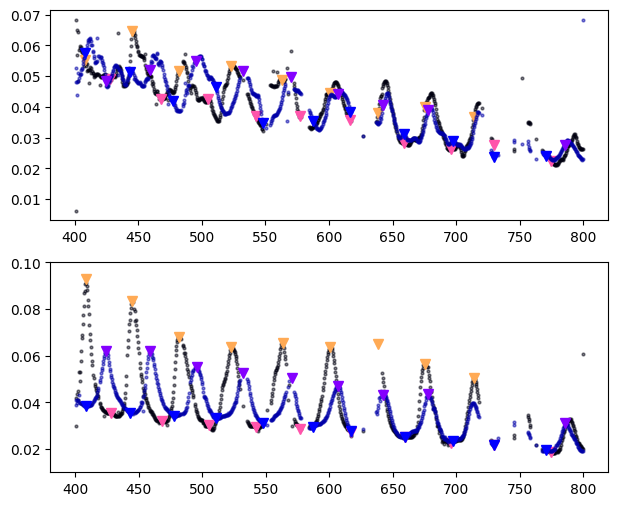

In [422]:
fig,[ax1,ax2]=subplots(nrows=2,ncols=1,figsize=(7.2,6))
ylim(0.01,0.1)
colorsarr=cm.gnuplot2(np.linspace(0,1,1200))

peaks=[1003,909,815,710,606,510,414,318,220]
troughs=[953,850,755,660,570,469,360,267,180,64]
ax1.plot(Dfits['Dfreq'],2.335*np.abs(Dfits['Dpoptmask'][:,210,0,2]),'.',c=colorsarr[20],alpha=0.5,markersize=4)
ax1.plot(Dfits['Dfreq'][peaks],2.335*np.abs(Dfits['Dpoptmask'][:,210,0,2])[peaks],'v',c=colorsarr[900],alpha=1,markersize=7)
ax1.plot(Dfits['Dfreq'][troughs],2.335*np.abs(Dfits['Dpoptmask'][:,210,0,2])[troughs],'v',c=colorsarr[700],alpha=1,markersize=7)
ax2.plot(Dfits['Dfreq'],2.335*np.abs(Dfits['Dpoptmask'][:,210,1,2]),'.',c=colorsarr[20],alpha=0.5,markersize=4)
ax2.plot(Dfits['Dfreq'][peaks],2.335*np.abs(Dfits['Dpoptmask'][:,210,1,2])[peaks],'v',c=colorsarr[900],alpha=1,markersize=7)
ax2.plot(Dfits['Dfreq'][troughs],2.335*np.abs(Dfits['Dpoptmask'][:,210,1,2])[troughs],'v',c=colorsarr[700],alpha=1,markersize=7)

peaks2=[962,873,779,686,588,494,403,312,36]
troughs2=[1003,913,826,740,645,545,469,360,262,180,74]
ax1.plot(Dfits['Dfreq'],2.335*np.abs(Dfits['Dpoptmask'][:,92,0,2]),'.',c=colorsarr[200],alpha=0.5,markersize=4)
ax1.plot(Dfits['Dfreq'][peaks2],2.335*np.abs(Dfits['Dpoptmask'][:,92,0,2])[peaks2],'v',c=colorsarr[500],alpha=1,markersize=7)
ax1.plot(Dfits['Dfreq'][troughs2],2.335*np.abs(Dfits['Dpoptmask'][:,92,0,2])[troughs2],'v',c=colorsarr[300],alpha=1,markersize=7)
ax2.plot(Dfits['Dfreq'],2.335*np.abs(Dfits['Dpoptmask'][:,92,1,2]),'.',c=colorsarr[200],alpha=0.5,markersize=4)
ax2.plot(Dfits['Dfreq'][peaks2],2.335*np.abs(Dfits['Dpoptmask'][:,92,1,2])[peaks2],'v',c=colorsarr[500],alpha=1,markersize=7)
ax2.plot(Dfits['Dfreq'][troughs2],2.335*np.abs(Dfits['Dpoptmask'][:,92,1,2])[troughs2],'v',c=colorsarr[300],alpha=1,markersize=7)

In [485]:
fax=range(troughs[7],peaks[7])
# fax=range(peaks[7],troughs[6])
df=len(fax)
print(fax[0],fax[-1])
print(Dfits['Dfreq'][fax[0]],Dfits['Dfreq'][fax[-1]])


267 317
695.703125 676.171875


13.155075727417731 -0.5901143744866225
[697.5 695.  692.5 690.  687.5 685.  682.5 680.  677.5 675. ]


/tmp/ipykernel_69560/180655136.py:34: UserWarning: FixedFormatter should only be used together with FixedLocator
  cbar.set_ticklabels(ctix)


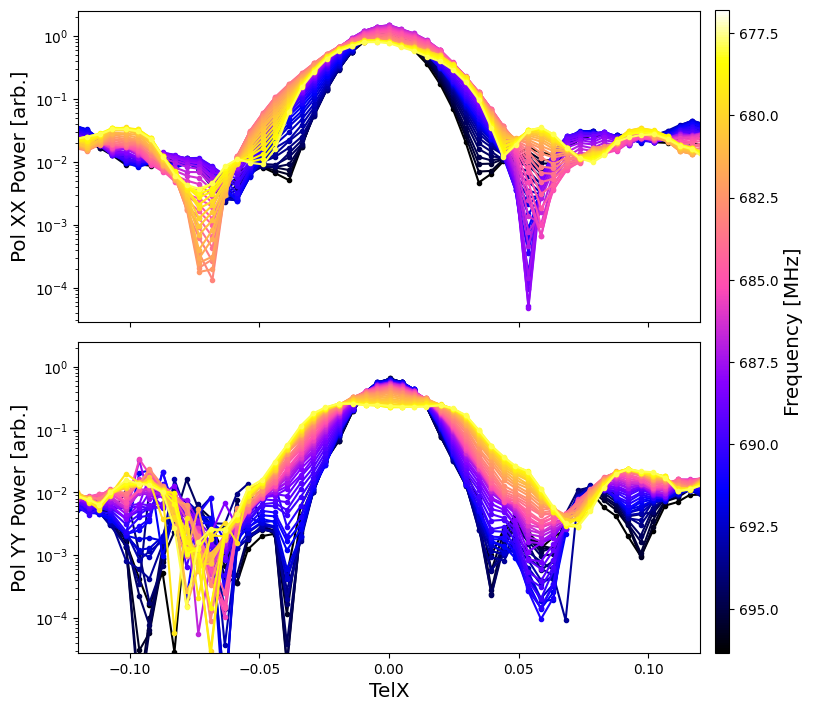

In [493]:
# RawDrone=np.load('../../Desktop/CHIME_IEEEpaper/CHIME_paperdata/Drone_Raw_eigen.npz')
# RawDrone=np.load('../../Desktop/Drone_Raw.npz')
#what TelY and Dec are shown here?
print(Dcoords['RA_Dec_per_feed'][190,1989,1],Dcoords['telXY_per_feed'][190,1989,1])

colorsarr=cm.gnuplot2(np.linspace(0,1,df+3))
fig,[ax1,ax2]=subplots(nrows=2,ncols=1,figsize=(7.2,7.2),sharex=True,sharey=True)

for k,ff in enumerate(fax):#(np.array([64,256,512,960])):
    for feed in (np.array([210])):#210
        for i,ax in enumerate([ax1,ax2]):
            ax.plot(RawDrone['telXY_per_feed{}'.format(['x','y'][i])][feed,:,0],RawDrone['V{}'.format(['x','y'][i])][:,ff,feed],'.-',c=colorsarr[k],alpha=1)#,label='{:.2f} MHz'.format(Dfits['Dfreq'][ff]))
#             synthX=np.linspace(RawDrone['telXY_per_feed{}'.format(['x','y'][i])][feed,0,0],RawDrone['telXY_per_feed{}'.format(['x','y'][i])][feed,-1,0],1000)
#             ax.plot(synthX,fu.Gauss(synthX,*Dfits['Dpoptmask'][ff,feed,i,:])/np.nanmax(Dfits['Dpoptmask'][ff,feed,i,0]),':',linewidth=2,c=colorsarr[k],alpha=0.5)
            

    for j,ax in enumerate([ax1,ax2]):
#         ax.set_facecolor('k')
#         ax.grid()
        ax.semilogy()
        ax.set_xlim(-0.12,0.12)
#         ax.set_ylim(1e-4,1.6e0)
        ax.set_xlabel('TelX' if j==1 else None,fontsize='x-large')
        ax.set_ylabel('Pol {} Power [arb.]'.format(['XX','YY'][j]),fontsize='x-large')
#         ax.legend(loc=8,fontsize='large')
#         ax.legend(loc=1,fontsize='small')
fig.tight_layout()

im=scatter(0*np.ones(df),-1*np.ones(df),c=Dfits['Dfreq'][fax],alpha=1,cmap='gnuplot2')
cbar_ax=fig.add_axes([1.0, 0.08788, 0.02, 0.893])
cbar=fig.colorbar(im, cax=cbar_ax)
ctix=cbar.get_ticks()[::-1]
print(ctix)
cbar.set_ticklabels(ctix)
cbar.set_label('Frequency [MHz]',fontsize='x-large')

# fig.savefig("../../Desktop/CHIME_IEEEpaper/CHIME_Figures/1d_Sidelobe_Freq_Sweep_1_a1.png")

MovieWriter ffmpeg unavailable; using Pillow instead.
/home/tyndall/python/beamcals_venv/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
/tmp/ipykernel_29017/576807243.py:24: RuntimeWarning: Mean of empty slice
  ax.plot(Dfits['Dfreq'],2.335*np.nanmean(np.abs(Dfits['Dpoptmask'][:,Dind-Davg:Dind+Davg,i,2]),axis=1),'.',c=colorsarr[50],alpha=0.3,label='Drone (Feeds {}$\pm${})'.format(Dind,Davg))


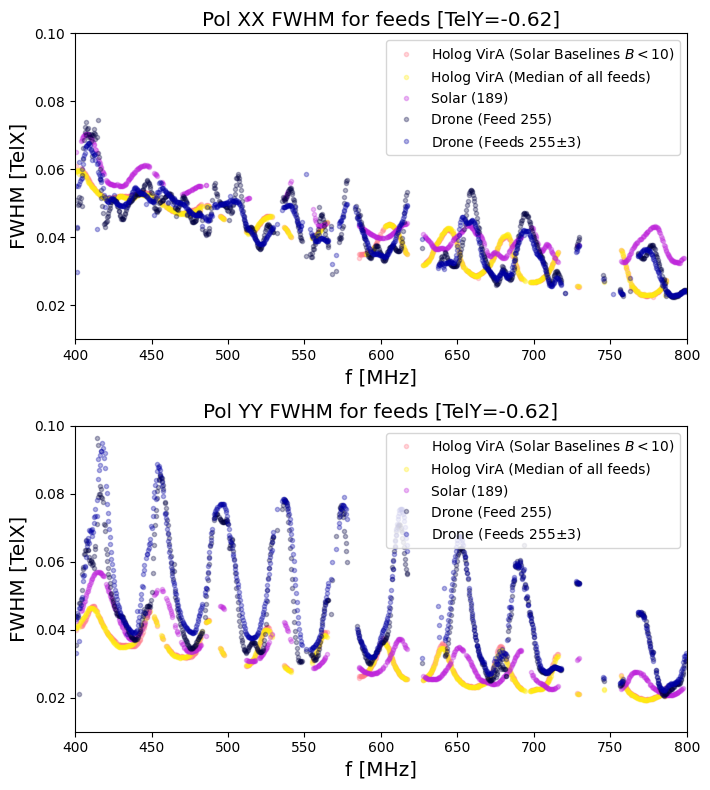

In [80]:
## Make a gif:
from matplotlib.animation import FuncAnimation
colorsarr=cm.gnuplot2(np.linspace(0,1,256+50))
Davg=3
Savg=1
fig,[ax1,ax2]=subplots(nrows=2,ncols=1,figsize=(7.2,8))

# for ni,Dind in enumerate(range(207,212)):
# for ni,Dind in enumerate(range(207,213)):
def animate(vvv):    
    Dind=vvv
    Sind=SThetaindperDroneFeed[Dind]
    for i,ax in enumerate([ax1,ax2]):
        ax.clear()
        ## Plot Holography:
        [ax.plot(Dfits['Dfreq'],np.abs(HologFWHM[j][:,Dind,i]),'.',c=colorsarr[200],alpha=0.3,label="Holog {} (Solar Baselines $B<10$)".format(Hsources[j])) for j in [0]]
        #[ax.plot(Dfits['Dfreq'],np.abs(HologFWHMPB[j][:,Dind,i]),'.',c=colorsarr[250],alpha=0.3,label="Holog {} (Feed {})".format(Hsources[j],Dind)) for j in [0]]
        [ax.plot(Dfits['Dfreq'],np.nanmedian(np.abs(HologFWHMPB[j][:,:,i]),axis=1),'.',c=colorsarr[270],alpha=0.3,label="Holog {} (Median of all feeds)".format(Hsources[j])) for j in [0]]
        ## Plot Solar:
        ax.plot(Sfits['Sfreq'],2.335*np.abs(Sfits['Spoptmask'][:,i,Sind,2]),'.',c=colorsarr[150],alpha=0.3,label='Solar ({})'.format(Sind))
        #ax.plot(Sfits['Sfreq'],np.nanmean(2.335*np.abs(Sfits['Spoptmask'][:,i,Sind-Savg:Sind+Savg,2]),axis=1),'x-',c=colorsarr[150],alpha=0.7,label='$[\Theta_y$={:.2f}] Solar (Thetas {}$\pm${})'.format(Sfits['Stheta'][Sind],Sind,Savg))
        ## Plot Drone:
        ax.plot(Dfits['Dfreq'],2.335*np.abs(Dfits['Dpoptmask'][:,Dind,i,2]),'.',c=colorsarr[20],alpha=0.3,label='Drone (Feed {})'.format(Dind))
        ax.plot(Dfits['Dfreq'],2.335*np.nanmean(np.abs(Dfits['Dpoptmask'][:,Dind-Davg:Dind+Davg,i,2]),axis=1),'.',c=colorsarr[50],alpha=0.3,label='Drone (Feeds {}$\pm${})'.format(Dind,Davg))    
        ## Plot formatting:
        ax.set_ylim(0.01,0.1)
        ax.set_xlim(400,800)
        ax.legend(loc=1)
        ax.set_title('Pol {} FWHM for feeds [TelY={:.2f}]'.format(Dfits['Dpols'][i],Dfits['telXY_per_feed'][:256,1989,1][Dind]),fontsize='x-large')
        ax.set_xlabel('f [MHz]',fontsize='x-large')
        ax.set_ylabel('FWHM [TelX]',fontsize='x-large')
        fig.tight_layout()
    print("{}".format(vvv),end='\r')
    
anim = FuncAnimation(fig, animate, interval=200, frames=256)
anim.save('../../Desktop/Newest.gif')
show()



In [699]:
stop
from matplotlib.animation import FuncAnimation
fig,[[ax1,ax2],[ax3,ax4]]=subplots(nrows=2,ncols=2,figsize=(7.2,6))

feedind=0
TelYxminind=np.where((RawDrone['telXY_per_feedx'][feedind,:,1])==np.nanmin(RawDrone['telXY_per_feedx'][feedind,:,1]))[0][0]
TelYyminind=np.where((RawDrone['telXY_per_feedy'][feedind,:,1])==np.nanmin(RawDrone['telXY_per_feedy'][feedind,:,1]))[0][0]
thetaind=np.abs(np.nanmin(RawDrone['telXY_per_feedy'][feedind,:,1])-RawSolar['Stheta']).argmin()
print(feedind,RawDrone['telXY_per_feedx'][feedind,TelYxminind,1],thetaind,RawSolar['Stheta'][thetaind])
## Generate Plot Coordinates:
flb,fub=[45,46]
# flb,fub=[77,78]
flb,fub=[280,282]
flb,fub=[0,1]
DXx,DYx=[RawDrone['telXY_per_feedx'][feedind,:,0],RawDrone['telXY_per_feedx'][:,TelYxminind,1]]
DXxgrid=np.meshgrid(DXx,DYx)[0]-np.outer(xxcentmean,np.ones(len(DXx)))
DYxgrid=np.meshgrid(DXx,DYx)[1]
DXy,DYy=[RawDrone['telXY_per_feedy'][feedind,:,0],RawDrone['telXY_per_feedy'][:,TelYyminind,1]]
DXygrid=np.meshgrid(DXy,DYy)[0]-np.outer(yycentmean,np.ones(len(DXy)))
DYygrid=np.meshgrid(DXy,DYy)[1]
SX,SY=[RawSolar['Sphi'],RawSolar['Stheta']]
## Generate Normalization from fits:
DNorm=(Dfits['Dpoptmask'][flb,:,:300,0]+Dfits['Dpoptmask'][flb,:,:300,3])
SNorm=(Sfits['Spoptmask'][flb,:,:300,0]+Sfits['Spoptmask'][flb,:,:300,3])

im1=ax1.pcolormesh(DXxgrid,DYxgrid,(np.nanmedian(np.abs(EigenDrone['Vx'][:,flb:fub,:]),axis=1)/np.outer(np.ones(len(DXx)),DNorm[:,0])).T)
im2=ax2.pcolormesh(DXygrid,DYygrid,(np.nanmedian(np.abs(EigenDrone['Vy'][:,flb:fub,:]),axis=1)/np.outer(np.ones(len(DXy)),DNorm[:,1])).T)
im3=ax3.pcolormesh(SX,SY,(np.nanmedian(np.abs(RawSolar['Sbx'][flb:fub,:,:]),axis=0)/np.outer(SNorm[0,:],np.ones(len(SX)))))
im4=ax4.pcolormesh(SX,SY,(np.nanmedian(np.abs(RawSolar['Sby'][flb:fub,:,:]),axis=0)/np.outer(SNorm[1,:],np.ones(len(SX)))))
images=[im1,im2,im3,im4]
for i,ax in enumerate([ax1,ax2,ax3,ax4]):
    images[i].set_cmap('gnuplot2')
    images[i].set_norm(LogNorm(vmin=1e-3,vmax=1e0))
#     images[i].set_clim(0.0,1.0)
    ax.set_facecolor(colorsarr[20])
    divider=make_axes_locatable(ax)
    cax=divider.append_axes("right", size="5%", pad=0.05)
    cbar=fig.colorbar(images[i],cax=cax)
    cbar.set_label('Normalized Power') 
    ax.set_xlim(-0.22,0.22)
    ax.set_ylim(-0.62,-.49)
    ax.set_xlabel("TelX")
    ax.set_ylabel("TelY [Feed]" if i<2 else "TelY")
tight_layout()

def animate(vvv):
    DNorm=(Dfits['Dpoptmask'][flb+vvv,:,:256,0]+Dfits['Dpoptmask'][flb+vvv,:,:256,3])
    SNorm=(Sfits['Spoptmask'][flb+vvv,:,:300,0]+Sfits['Spoptmask'][flb+vvv,:,:300,3])
    im1.set_array((np.nanmedian(np.abs(EigenDrone['Vx'][:,flb+vvv:fub+vvv,:]),axis=1)/np.outer(np.ones(len(DXx)),DNorm[:,0])).T)
    im2.set_array((np.nanmedian(np.abs(EigenDrone['Vy'][:,flb+vvv:fub+vvv,:]),axis=1)/np.outer(np.ones(len(DXy)),DNorm[:,1])).T)
    im3.set_array((np.nanmedian(np.abs(RawSolar['Sbx'][flb+vvv:fub+vvv,:,:]),axis=0)/np.outer(SNorm[0,:],np.ones(len(SX)))))
    im4.set_array((np.nanmedian(np.abs(RawSolar['Sby'][flb+vvv:fub+vvv,:,:]),axis=0)/np.outer(SNorm[1,:],np.ones(len(SX)))))
    for i,ax in enumerate([ax1,ax2,ax3,ax4]):
        images[i].set_cmap('gnuplot2')
        images[i].set_norm(LogNorm(vmin=1e-3,vmax=1e0))
        ax.set_title("{} [{:.2f}MHz]".format(["Drone XX","Drone YY","Solar XX","Solar YY"][i],Dfits['Dfreq'][vvv+flb]))
    print("{}".format(vvv),end='\r')
    
anim = FuncAnimation(fig, animate, interval=300, frames=1)
anim.save('../../Desktop/Funny1.gif')
show()

NameError: name 'stop' is not defined